# The INStarCraft 2 Player Prediction Challenge
### Fabian Schröder, HUANG Xuanhao, QI Jiaqi


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN_LONG.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/SAMPLE_SUBMISSION.CSV
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST_LONG.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST.CSV.GZ


# Exploratory Data Analysis

In [3]:
import gzip
from sklearn.utils import resample
from collections import Counter

# Read csv data from gz
def read_ds(ds):
    with gzip.open(ds) as f:
        max_actions = max(( len(str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names = _names, dtype = str)

### When we display the TRAIN dataset, we observe that we have many missing values in the last columns and that our data type is String. Not only that, we know that our data is sequential. So we have two main ways to process our data:
* Extract and create new features to characterize matches and players
* Build ML models using sequential data

In [4]:
# Display TRAIN data
df = read_ds('/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN.CSV.GZ')
#df.head()
#df.tail()
df.sample(frac = 0.1, random_state = 500)

battleneturl played_race     0  \
2598  http://kr.battle.net/sc2/en/profile/2344079/1/...        Zerg     s   
2452  http://kr.battle.net/sc2/en/profile/2342671/1/...     Protoss  Base   
2100  http://us.battle.net/sc2/en/profile/2735594/1/...      Terran     s   
2672  http://kr.battle.net/sc2/en/profile/2343559/1/...     Protoss  Base   
1748  http://eu.battle.net/sc2/en/profile/1430346/1/...     Protoss  Base   
...                                                 ...         ...   ...   
2567  http://kr.battle.net/sc2/en/profile/2341575/1/...     Protoss  Base   
30    http://eu.battle.net/sc2/en/profile/2452136/1/...     Protoss  Base   
823   http://kr.battle.net/sc2/en/profile/2342419/1/...        Zerg     s   
2185  http://us.battle.net/sc2/en/profile/5393959/1/...        Zerg     s   
2098  http://us.battle.net/sc2/en/profile/2735594/1/...      Terran     s   

                  1              2         3         4              5  \
2598              s              s         s         s              s   
2452              s              s      Base         s       hotkey40   
2100  SingleMineral              s         s  hotkey10  SingleMineral   
2672              s              s         s      Base              s   
1748              s       hotkey30  hotkey10  hotkey20             t5   
...             ...            ...       ...       ...            ...   
2567              s              s         s      Base              s   
30                s       hotkey90  hotkey00        t5            t10   
823               s              s         s         s              s   
2185              s              s         s         s              s   
2098       hotkey10  SingleMineral         s  hotkey12             t5   

             6              7  ... 10527 10528 10529 10530 10531 10532 10533  \
2598         s       hotkey10  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2452         s       hotkey10  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2100         s       hotkey12  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2672  hotkey10             t5  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1748       t10              s  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...        ...            ...  ...   ...   ...   ...   ...   ...   ...   ...   
2567  hotkey10              s  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
30         t15              s  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
823   hotkey50              s  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2185         s             t5  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2098       t10  SingleMineral  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

     10534 10535 10536  
2598   NaN   NaN   NaN  
2452   NaN   NaN   NaN  
2100   NaN   NaN   NaN  
2672   NaN   NaN   NaN  
1748   NaN   NaN   NaN  
...    ...   ...   ...  
2567   NaN   NaN   NaN  
30     NaN   NaN   NaN  
823    NaN   NaN   NaN  
2185   NaN   NaN   NaN  
2098   NaN   NaN   NaN  

[305 rows x 10539 columns]

### For the TRAIN_LONG dataset, it contains more details and more specified events. 

In [5]:
# Display TRAIN_LONG data
# Set display options to show more rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_L = read_ds('/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN_LONG.CSV.GZ')
df_L.sample(frac = 0.03, random_state = 500)

battleneturl played_race  \
2598  http://kr.battle.net/sc2/en/profile/2344079/1/...        Zerg   
2452  http://kr.battle.net/sc2/en/profile/2342671/1/...     Protoss   
2100  http://us.battle.net/sc2/en/profile/2735594/1/...      Terran   
2672  http://kr.battle.net/sc2/en/profile/2343559/1/...     Protoss   
1748  http://eu.battle.net/sc2/en/profile/1430346/1/...     Protoss   
131   http://eu.battle.net/sc2/en/profile/4234852/1/...     Protoss   
2176  http://us.battle.net/sc2/en/profile/4174681/1/...     Protoss   
1835  http://us.battle.net/sc2/en/profile/2553612/1/...     Protoss   
2972  http://xx.battle.net/sc2/en/profile/414/1/ducK...     Protoss   
2719  http://kr.battle.net/sc2/en/profile/2344476/1/...        Zerg   
1271  http://kr.battle.net/sc2/en/profile/2342343/1/...        Zerg   
2252  http://kr.battle.net/sc2/en/profile/2343531/1/...      Terran   
1385  http://eu.battle.net/sc2/en/profile/2898004/1/...      Terran   
1659  http://eu.battle.net/sc2/en/profile/3090974/1/...      Terran   
475   http://us.battle.net/sc2/en/profile/3985949/1/...      Terran   
1889  http://us.battle.net/sc2/en/profile/3650249/1/...     Protoss   
2845  http://kr.battle.net/sc2/en/profile/2342343/1/...        Zerg   
966   http://kr.battle.net/sc2/en/profile/2343263/1/...     Protoss   
337   http://eu.battle.net/sc2/en/profile/2896854/1/...      Terran   
1933  http://us.battle.net/sc2/en/profile/4669755/1/...        Zerg   
2456  http://kr.battle.net/sc2/en/profile/2343733/1/...     Protoss   
589   http://us.battle.net/sc2/en/profile/2133676/1/...        Zerg   
2195  http://us.battle.net/sc2/en/profile/4589387/1/...        Zerg   
243   http://eu.battle.net/sc2/en/profile/3973341/1/...     Protoss   
177   http://eu.battle.net/sc2/en/profile/4149248/1/...      Terran   
377   http://eu.battle.net/sc2/en/profile/4064798/1/...      Terran   
760   http://us.battle.net/sc2/en/profile/902213/1/S...        Zerg   
1643  http://eu.battle.net/sc2/en/profile/884897/1/L...        Zerg   
1092  http://kr.battle.net/sc2/en/profile/2342343/1/...        Zerg   
1174  http://kr.battle.net/sc2/en/profile/2343067/1/...     Protoss   
1024  http://kr.battle.net/sc2/en/profile/2341467/1/...     Protoss   
2876  http://kr.battle.net/sc2/en/profile/2344081/1/...      Terran   
1164  http://kr.battle.net/sc2/en/profile/2343067/1/...     Protoss   
492   http://us.battle.net/sc2/en/profile/902213/1/S...        Zerg   
1560  http://eu.battle.net/sc2/en/profile/3880481/1/...     Protoss   
1240  http://kr.battle.net/sc2/en/profile/2344285/1/...     Protoss   
549   http://us.battle.net/sc2/en/profile/5376901/1/...        Zerg   
1755  http://eu.battle.net/sc2/en/profile/2222468/1/...        Zerg   
2938  http://kr.battle.net/sc2/en/profile/2343733/1/...     Protoss   
200   http://eu.battle.net/sc2/en/profile/884897/1/L...        Zerg   
602   http://us.battle.net/sc2/en/profile/5142993/1/...      Terran   
790   http://kr.battle.net/sc2/en/profile/2342419/1/...        Zerg   
417   http://eu.battle.net/sc2/en/profile/3010872/1/...     Protoss   
2477  http://kr.battle.net/sc2/en/profile/2344333/1/...        Zerg   
2747  http://kr.battle.net/sc2/en/profile/2341466/1/...     Protoss   
880   http://kr.battle.net/sc2/en/profile/2342794/1/...        Zerg   
1222  http://kr.battle.net/sc2/en/profile/2344285/1/...     Protoss   
314   http://eu.battle.net/sc2/en/profile/3401218/1/...     Protoss   
2132  http://us.battle.net/sc2/en/profile/3949344/1/...      Terran   
53    http://eu.battle.net/sc2/en/profile/4341883/1/...     Protoss   
253   http://eu.battle.net/sc2/en/profile/3973341/1/...     Protoss   
34    http://eu.battle.net/sc2/en/profile/3074362/1/...     Protoss   
159   http://eu.battle.net/sc2/en/profile/3090974/1/...      Terran   
2124  http://us.battle.net/sc2/en/profile/4408675/1/...      Terran   
780   http://us.battle.net/sc2/en/profile/558433/1/I...      Terran   
1853  http://us.battle.net/sc2/en/profile/2537456/1/...      Terran

# Data Visualization

### First, we display the distribution of some features to get more information. It's just to get more information and understand better the dataset.
### For example, about the distribution of the race, maybe we can say Terran is less popular than Protoss. 

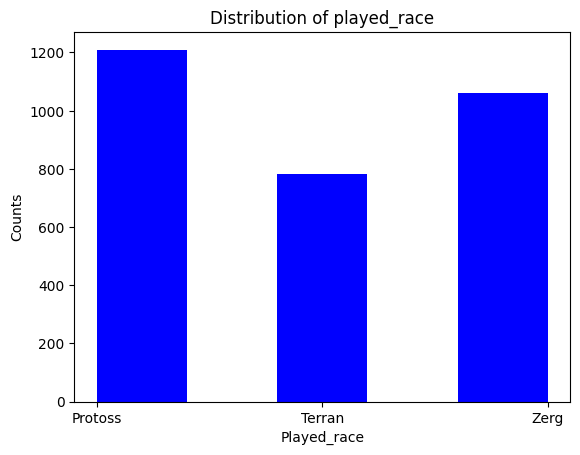

In [6]:
import matplotlib.pyplot as plt
df['played_race'].hist(bins=5, grid=False, color='blue')
plt.title('Distribution of played_race')
plt.xlabel('Played_race')
plt.ylabel('Counts')
plt.show()

### This image shows the choice of race for different players. For example, most players only play the same race.

played_race
Protoss    58
Name: count, dtype: int64
played_race
Zerg    51
Name: count, dtype: int64
played_race
Terran    39
Name: count, dtype: int64


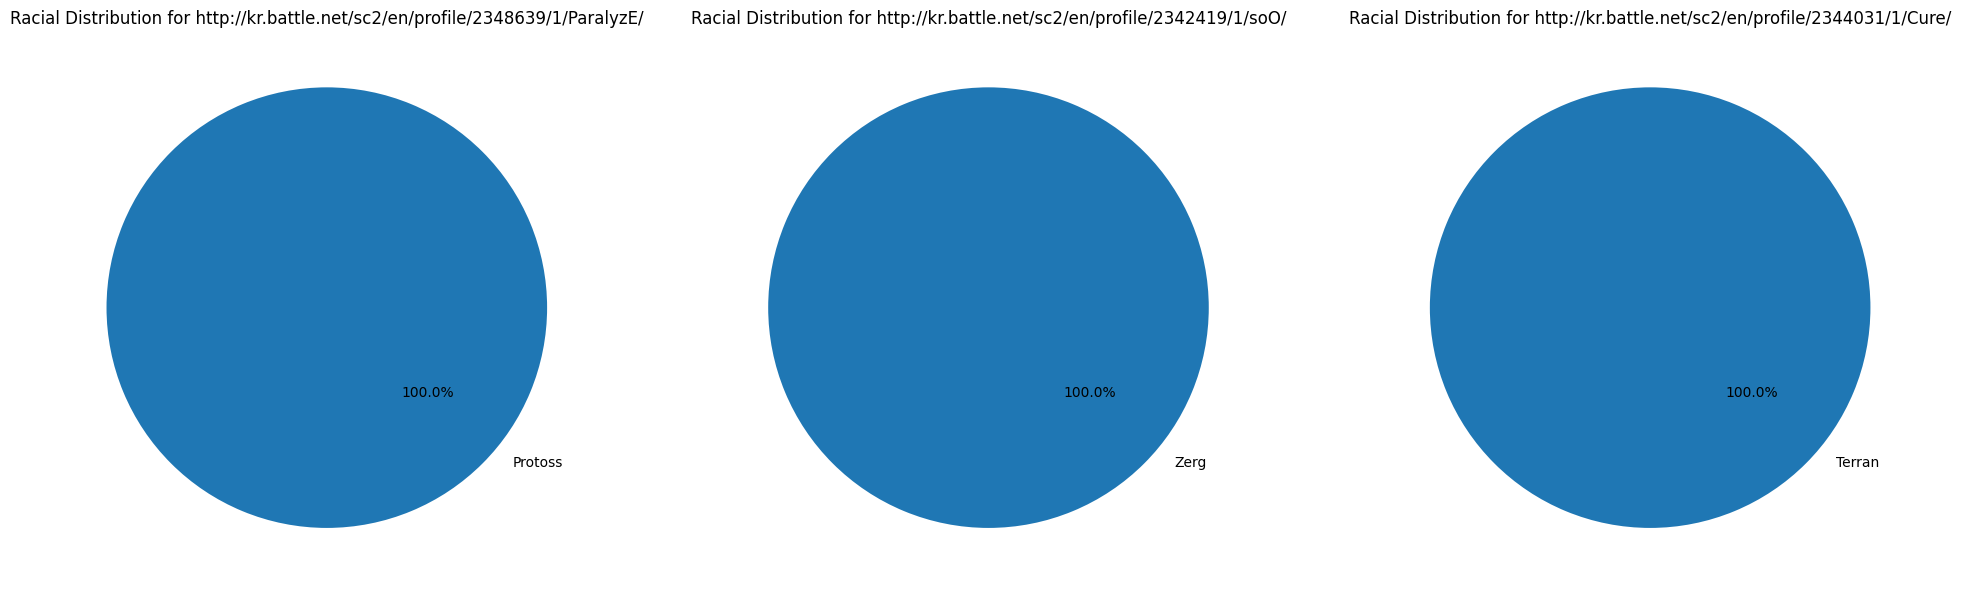

In [88]:
player_0 = df['battleneturl'].value_counts().reset_index().iloc[0]['battleneturl']
# df_0 = df[df['battleneturl'] == player_0]
# race_0 = df_0['played_race'].value_counts()
player_1 = df['battleneturl'].value_counts().reset_index().iloc[1]['battleneturl']
player_2 = df['battleneturl'].value_counts().reset_index().iloc[6]['battleneturl']

players_of_interest = [player_0, player_1, player_2]
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
for i, player in enumerate(players_of_interest):
    player_df = df[df['battleneturl'] == player]
    race_counts = player_df['played_race'].value_counts()
    axs[i].pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
    axs[i].set_title(f'Racial Distribution for {player}')
plt.tight_layout()
plt.show()

### Second, we want to know the distribution of our label. We notice that our dataset is unbalanced, so we try two basic solutions like: **Oversampling** and **Stratified Validation**.

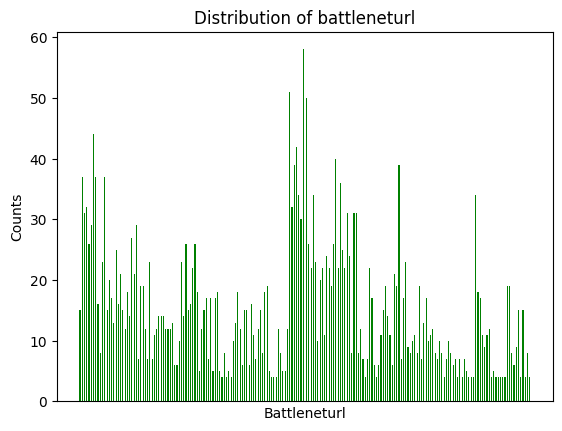

In [8]:
df['battleneturl'].hist(bins=400, grid=False, color='green')
plt.title('Distribution of battleneturl')
plt.xlabel('Battleneturl')
plt.xticks([])  # remove x-axis ticks
plt.ylabel('Counts')
plt.show()

### Third, we focus on missing values. We show the number of missing value in each column. As we can see, starting at roughly 4000+ columns, our dataset becomes very sparse. Almost the entire dataset is missing value.

### If we want to use sequential data, a simple segmentation maybe is a good choice.

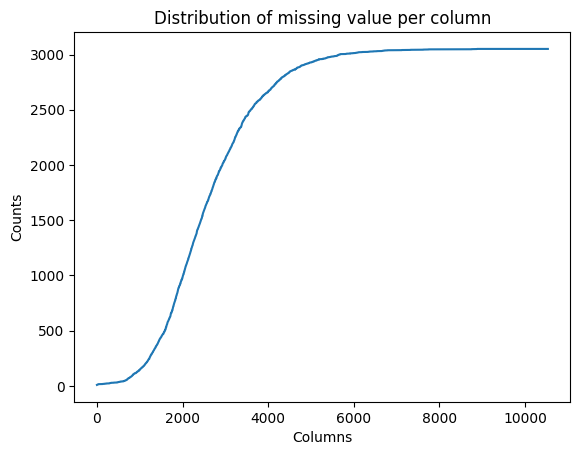

In [9]:
missing_values_per_col = []
for i in range(2, len(df.columns)): # +1
    missing_values_per_col.append(df.iloc[:, i].isnull().sum())
plt.figure()
plt.title('Distribution of missing value per column')
plt.xlabel('Columns')
plt.ylabel('Counts')
plt.plot(missing_values_per_col)
plt.show()

### Finally, it's some additional information about the dataset. We can get a better sense of our unbalanced dataset and how much the length of matches has changed.

In [10]:
# Count player
print(df['battleneturl'].value_counts().reset_index())
# Count the null value
for column, missing_count in df.isnull().sum().items():
    if missing_count > 1000:
        print(f"First column which has more than 1000 missing values: {column}")
        break
# Mean count value
print(f"Average number of each player: {df['battleneturl'].value_counts().mean()}")

# # Query race
# df.query('played_race == "Terran"') # Zerg: 1061, Protoss:1210
# # df.loc[df['played_race'] == 'Protoss']

                                          battleneturl  count
0    http://kr.battle.net/sc2/en/profile/2348639/1/...     58
1    http://kr.battle.net/sc2/en/profile/2342419/1/...     51
2    http://kr.battle.net/sc2/en/profile/2341467/1/...     50
3    http://eu.battle.net/sc2/en/profile/3973341/1/...     44
4    http://kr.battle.net/sc2/en/profile/2332264/1/...     42
..                                                 ...    ...
195  http://us.battle.net/sc2/en/profile/2060165/1/...      4
196  http://us.battle.net/sc2/en/profile/2192180/1/...      4
197  http://eu.battle.net/sc2/en/profile/3434150/1/...      4
198  http://eu.battle.net/sc2/en/profile/4860568/1/...      4
199     http://xx.battle.net/sc2/en/profile/405/1/MMA/      4

[200 rows x 2 columns]
First column which has more than 1000 missing values: 2013
Average number of each player: 15.26


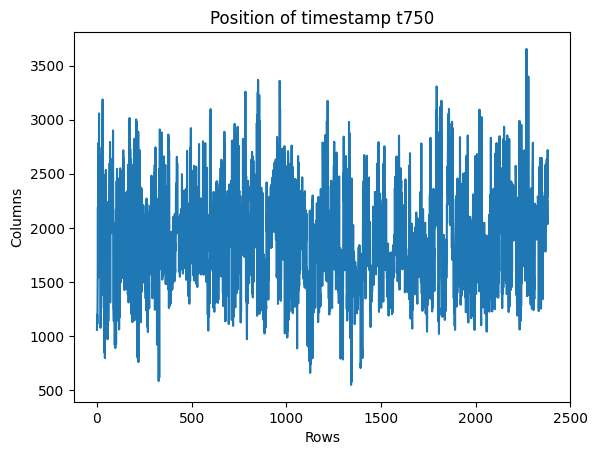

Average column of timestamp t750's position: 1879.9151973131823
Max column of timestamp t750's position: 3654
Min column of timestamp t750's position: 547


In [11]:
# Position of timestamp for sequence model
icol = []
for index, row in df.iloc[:,2:].iterrows():
    for column, value in row.items():
        if value == 't750':
            icol.append(column)
            break
plt.figure()
plt.title('Position of timestamp t750')
plt.xlabel('Rows')
plt.ylabel('Columns')
plt.plot(icol)
plt.show()

print(f"Average column of timestamp t750's position: {sum(icol) / len(icol)}")  
print(f"Max column of timestamp t750's position: {max(icol)}")  
print(f"Min column of timestamp t750's position: {min(icol)}")  

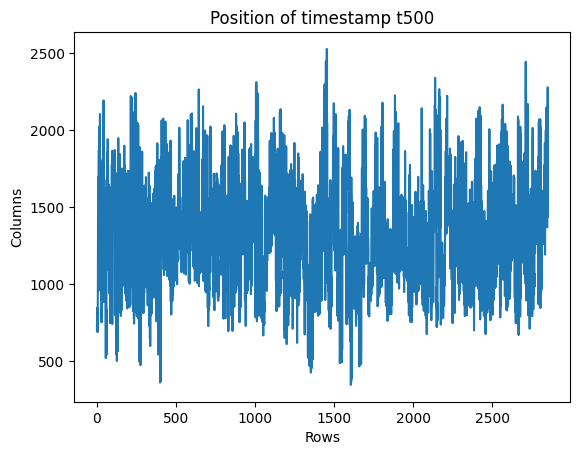

Average column of timestamp t500's position: 1302.8885383806519
Max column of timestamp t500's position: 2526
Min column of timestamp t500's position: 345


In [87]:
# Position of timestamp for sequence model
icol = []
for index, row in df.iloc[:,2:].iterrows():
    for column, value in row.items():
        if value == 't500':
            icol.append(column)
            break
plt.figure()
plt.title('Position of timestamp t500')
plt.xlabel('Rows')
plt.ylabel('Columns')
plt.plot(icol)
plt.savefig('t500.png')
plt.show()

print(f"Average column of timestamp t500's position: {sum(icol) / len(icol)}")  
print(f"Max column of timestamp t500's position: {max(icol)}")  
print(f"Min column of timestamp t500's position: {min(icol)}")  

# Feature Engineering

### First, we remove rows with missing values in column 0, battleneturl and played_race. Because Either important information is missing or there is no action. About the TRAIN_LONG dataset, we just delete what we removed in the TRAIN dataset.

In [13]:
# Remove rows with missing values in column 0, battleneturl and played_race
def remove_nan(df):
    df = df.dropna(subset=[0, 'battleneturl', 'played_race'], inplace=True)

# Get removed row's index
def remove_display_nan(df):
    original_index = df.index.tolist()
    df.dropna(subset=[0, 'battleneturl', 'played_race'], inplace=True)
    new_index = df.index.tolist()
    removed_index = list(set(original_index) - set(new_index))
    print("Removed rows:", removed_index)
    return removed_index

In [14]:
# Remove 0 operation row
print(df.info())
index_removed = remove_display_nan(df)
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Columns: 10539 entries, battleneturl to 10536
dtypes: object(10539)
memory usage: 245.4+ MB
None
Removed rows: [672, 577, 578, 678, 679, 1883, 1884, 671]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Columns: 10539 entries, battleneturl to 10536
dtypes: object(10539)
memory usage: 244.8+ MB
None


In [15]:
# Remove 0 operation row
print(df_L.info())
# remove_display_nan(df_L)
df_L.drop(index_removed, inplace=True)
df_L = df_L.reset_index(drop=True)
print(df_L.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Columns: 26825 entries, battleneturl to 26822
dtypes: object(26825)
memory usage: 624.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Columns: 26825 entries, battleneturl to 26822
dtypes: object(26825)
memory usage: 623.0+ MB
None


### Our first idea is to count the number of each operation. About the hotkey part, we count the hotkey from 0 to 9 and also the numer of times **created**, **updated** and **used**. Because we think that as the game goes on, some players like to change their keystrokes. Finally, we add the number of timestamp to represent the match duration.

In [16]:
def create_df(df):
    mineral = (df == 'SingleMineral').sum(axis=1)
    base = (df == 'Base').sum(axis=1)
    select = (df == 's').sum(axis=1)
    created = r'^hotkey.*0$'
    hk_cr = df.apply(lambda x: x.str.contains(created)).sum(axis=1)
    updated = r'^hotkey.*1$'
    hk_up = df.apply(lambda x: x.str.contains(updated)).sum(axis=1)
    used = r'^hotkey.*2$'
    hk_us = df.apply(lambda x: x.str.contains(used)).sum(axis=1)
    timestamp = r't\d+'
    TS = df.apply(lambda x: x.str.contains(timestamp)).sum(axis=1)
    hk0 = r'hotkey0\d+'
    hk1 = r'hotkey1\d+'
    hk2 = r'hotkey2\d+'
    hk3 = r'hotkey3\d+'
    hk4 = r'hotkey4\d+'
    hk5 = r'hotkey5\d+'
    hk6 = r'hotkey6\d+'
    hk7 = r'hotkey7\d+'
    hk8 = r'hotkey8\d+'
    hk9 = r'hotkey9\d+'
    nb_hk0 = df.apply(lambda x: x.str.contains(hk0)).sum(axis=1)
    nb_hk1 = df.apply(lambda x: x.str.contains(hk1)).sum(axis=1)
    nb_hk2 = df.apply(lambda x: x.str.contains(hk2)).sum(axis=1)
    nb_hk3 = df.apply(lambda x: x.str.contains(hk3)).sum(axis=1)
    nb_hk4 = df.apply(lambda x: x.str.contains(hk4)).sum(axis=1)
    nb_hk5 = df.apply(lambda x: x.str.contains(hk5)).sum(axis=1)
    nb_hk6 = df.apply(lambda x: x.str.contains(hk6)).sum(axis=1)
    nb_hk7 = df.apply(lambda x: x.str.contains(hk7)).sum(axis=1)
    nb_hk8 = df.apply(lambda x: x.str.contains(hk8)).sum(axis=1)
    nb_hk9 = df.apply(lambda x: x.str.contains(hk9)).sum(axis=1)
    data = {
    'hk_cr': hk_cr, 'hk_up': hk_up, 'hk_us': hk_us,
    'hk0': nb_hk0, 'hk1': nb_hk1, 'hk2': nb_hk2, 'hk3': nb_hk3,
    'hk4': nb_hk4, 'hk5': nb_hk5, 'hk6': nb_hk6,
    'hk7': nb_hk7, 'hk8': nb_hk8, 'hk9': nb_hk9,
    'TS': TS, 'selection': select, 'mineral': mineral, 'base': base
    }
    df_new = pd.DataFrame(data)
    return df_new

In [17]:
# Generate new data set
X = create_df(df)
X = X.astype(float)
X.head()

hk_cr  hk_up   hk_us   hk0    hk1    hk2    hk3    hk4    hk5   hk6  hk7  \
0  123.0    0.0  1364.0  46.0  413.0  222.0  402.0  260.0  118.0  21.0  1.0   
1   94.0    3.0  1430.0  85.0  516.0  230.0  349.0  311.0    0.0   0.0  0.0   
2   43.0    0.0   825.0  21.0  147.0  135.0  321.0  137.0   91.0  12.0  0.0   
3   58.0    1.0   911.0  41.0  292.0   84.0  251.0  287.0    0.0   0.0  0.0   
4   21.0    0.0   388.0   1.0   62.0   44.0  201.0   86.0   15.0   0.0  0.0   

    hk8   hk9     TS  selection  mineral  base  
0   0.0   4.0  331.0      674.0      5.0  66.0  
1  17.0  19.0  331.0      538.0      0.0  12.0  
2   0.0   4.0  202.0      430.0      3.0  47.0  
3   0.0  15.0  201.0      397.0      0.0  21.0  
4   0.0   0.0  108.0      208.0      0.0   2.0

### Our second idea is to process the TRAIN_LONG dataset in a same way. We count the number of each event. We feel that almost any event can describe a player's gaming habits.

### For example, some players like to chat and interact with their opponents, while others prefer to play quietly.

In [18]:
# Extract new features
def count_event(df):
    chat = df.apply(lambda x: x.str.contains("ChatEvent").sum(), axis=1)
    selection_L = df.apply(lambda x: x.str.contains("SelectionEvent").sum(), axis=1)
    camera = df.apply(lambda x: x.str.contains("CameraEvent").sum(), axis=1)
    target_point = df.apply(lambda x: x.str.contains("TargetPointCommandEvent").sum(), axis=1)
    control = df.apply(lambda x: x.str.contains("ControlGroupEvent").sum(), axis=1)
    target_unit = df.apply(lambda x: x.str.contains("TargetUnitCommandEvent").sum(), axis=1)
    basic_L = df.apply(lambda x: x.str.contains("BasicCommandEvent").sum(), axis=1)
    TS_L = df.notnull().sum(axis=1)
    return chat, selection_L, camera, target_point, control, target_unit, basic_L, TS_L

### After we follow a closer look at the TRAIN_LONG dataset, we discover that going from A to B is a habit that varies from player to player.

### For example, player C likes to click from point A all the way to point B. However, player D clicks on point B only once and then goes on to do other actions, like moving the camera, checking the status of the mineral and base, etc.

### Therefore, we count the number of **TargetPoint** events that are three times in a row.

In [19]:
# Count successive clicks
def count_succ_click(df):
    succ_click = []
    for index, row in df.iloc[:,2:].iterrows():
        sc_row = 0
        sc = 0
        for column, value in row.items():
            if pd.isna(value):
                break
            elif "TargetPoint" in value:
                sc += 1
                if sc == 3:
                    sc_row += 1
                    sc = 0
            else:
                sc = 0
        succ_click.append(sc_row)
    return succ_click

In [20]:
succ_select = count_succ_click(df_L)
X['succ_click'] = succ_select
X.head()

hk_cr  hk_up   hk_us   hk0    hk1    hk2    hk3    hk4    hk5   hk6  hk7  \
0  123.0    0.0  1364.0  46.0  413.0  222.0  402.0  260.0  118.0  21.0  1.0   
1   94.0    3.0  1430.0  85.0  516.0  230.0  349.0  311.0    0.0   0.0  0.0   
2   43.0    0.0   825.0  21.0  147.0  135.0  321.0  137.0   91.0  12.0  0.0   
3   58.0    1.0   911.0  41.0  292.0   84.0  251.0  287.0    0.0   0.0  0.0   
4   21.0    0.0   388.0   1.0   62.0   44.0  201.0   86.0   15.0   0.0  0.0   

    hk8   hk9     TS  selection  mineral  base  succ_click  
0   0.0   4.0  331.0      674.0      5.0  66.0         354  
1  17.0  19.0  331.0      538.0      0.0  12.0           7  
2   0.0   4.0  202.0      430.0      3.0  47.0         172  
3   0.0  15.0  201.0      397.0      0.0  21.0           9  
4   0.0   0.0  108.0      208.0      0.0   2.0          80

In [21]:
# Add TRAIN_LONG features
chat, selection_L, camera, target_point, control, target_unit, basic_L, TS_L = count_event(df_L)
X['chat'] = chat
X['selection_L'] = selection_L
X['target_point'] = target_point
X['target_unit'] = target_unit
X['basic_L'] = basic_L
X['camera'] = camera
X['control'] = control
X['TS_L'] = TS_L
# [i/j for i, j in zip(target_point, TS_L)]
X = X.astype(float)
X.head()

hk_cr  hk_up   hk_us   hk0    hk1    hk2    hk3    hk4    hk5   hk6  hk7  \
0  123.0    0.0  1364.0  46.0  413.0  222.0  402.0  260.0  118.0  21.0  1.0   
1   94.0    3.0  1430.0  85.0  516.0  230.0  349.0  311.0    0.0   0.0  0.0   
2   43.0    0.0   825.0  21.0  147.0  135.0  321.0  137.0   91.0  12.0  0.0   
3   58.0    1.0   911.0  41.0  292.0   84.0  251.0  287.0    0.0   0.0  0.0   
4   21.0    0.0   388.0   1.0   62.0   44.0  201.0   86.0   15.0   0.0  0.0   

    hk8   hk9     TS  selection  mineral  base  succ_click  chat  selection_L  \
0   0.0   4.0  331.0      674.0      5.0  66.0       354.0   1.0        674.0   
1  17.0  19.0  331.0      538.0      0.0  12.0         7.0   0.0        538.0   
2   0.0   4.0  202.0      430.0      3.0  47.0       172.0   0.0        430.0   
3   0.0  15.0  201.0      397.0      0.0  21.0         9.0   1.0        397.0   
4   0.0   0.0  108.0      208.0      0.0   2.0        80.0   1.0        208.0   

   target_point  target_unit  basic_L  camera  control    TS_L  
0        2091.0        629.0    163.0  1648.0   1487.0  6695.0  
1        1214.0        472.0    198.0  1555.0   1527.0  5506.0  
2        1068.0        602.0    140.0   845.0    868.0  3955.0  
3         512.0        386.0    131.0   919.0    970.0  3318.0  
4         423.0        409.0     44.0   473.0    409.0  1969.0

### Our third idea is to count the maximun of APM (actions per minute) between two timestamps. Because some players operate significantly more often and faster than others, and even in games where subtle operations are more important, this number becomes an important indicator of a player's performance.

In [22]:
# Count the max operation between two timestamp
def max_apm(df):
    apm = []
    for index, row in df.iloc[:, 2:].iterrows():
        max_apm = 0
        cur_apm = 0
        for column, value in row.items():
            # end of data
            if pd.isna(value):
                break
            # timestamp 
            elif value[0].lower() == 't':
                max_apm = max(max_apm, cur_apm)
                cur_apm = 0
            else:
                cur_apm += 1
        apm.append(max_apm)
    return apm

In [23]:
# Add max apm
X['max_apm'] = max_apm(df)
X = X.astype(float)
X.head()

hk_cr  hk_up   hk_us   hk0    hk1    hk2    hk3    hk4    hk5   hk6  hk7  \
0  123.0    0.0  1364.0  46.0  413.0  222.0  402.0  260.0  118.0  21.0  1.0   
1   94.0    3.0  1430.0  85.0  516.0  230.0  349.0  311.0    0.0   0.0  0.0   
2   43.0    0.0   825.0  21.0  147.0  135.0  321.0  137.0   91.0  12.0  0.0   
3   58.0    1.0   911.0  41.0  292.0   84.0  251.0  287.0    0.0   0.0  0.0   
4   21.0    0.0   388.0   1.0   62.0   44.0  201.0   86.0   15.0   0.0  0.0   

    hk8   hk9     TS  selection  mineral  base  succ_click  chat  selection_L  \
0   0.0   4.0  331.0      674.0      5.0  66.0       354.0   1.0        674.0   
1  17.0  19.0  331.0      538.0      0.0  12.0         7.0   0.0        538.0   
2   0.0   4.0  202.0      430.0      3.0  47.0       172.0   0.0        430.0   
3   0.0  15.0  201.0      397.0      0.0  21.0         9.0   1.0        397.0   
4   0.0   0.0  108.0      208.0      0.0   2.0        80.0   1.0        208.0   

   target_point  target_unit  basic_L  camera  control    TS_L  max_apm  
0        2091.0        629.0    163.0  1648.0   1487.0  6695.0     21.0  
1        1214.0        472.0    198.0  1555.0   1527.0  5506.0     16.0  
2        1068.0        602.0    140.0   845.0    868.0  3955.0     20.0  
3         512.0        386.0    131.0   919.0    970.0  3318.0     16.0  
4         423.0        409.0     44.0   473.0    409.0  1969.0     19.0

### Finally, we decide to keep the **race** feature using a simple mapping. We have already tried the one-hot coding which is in the commentary below. In our opinion, judging by the results, there shouldn't be any major difference. However, when we choose a model such as a decision tree, race will become three separate conditions, which will increase the complexity of our tree. Since we already have almost 30 features, we didn't continue to use one-hot coding. But we add artificial ordinal relationships that do not exist originally with our mapping.

In [24]:
def add_race(df, X):
    mapping = {'Terran': 1, 'Zerg': 2, 'Protoss': 3}
    X['race'] = df['played_race'].map(mapping).copy()
    return X

In [25]:
# Add race column
X = add_race(df, X)
#X = pd.get_dummies(X, columns=['race']) # One-Hot coding
X = X.astype(float)
X.head()

hk_cr  hk_up   hk_us   hk0    hk1    hk2    hk3    hk4    hk5   hk6  hk7  \
0  123.0    0.0  1364.0  46.0  413.0  222.0  402.0  260.0  118.0  21.0  1.0   
1   94.0    3.0  1430.0  85.0  516.0  230.0  349.0  311.0    0.0   0.0  0.0   
2   43.0    0.0   825.0  21.0  147.0  135.0  321.0  137.0   91.0  12.0  0.0   
3   58.0    1.0   911.0  41.0  292.0   84.0  251.0  287.0    0.0   0.0  0.0   
4   21.0    0.0   388.0   1.0   62.0   44.0  201.0   86.0   15.0   0.0  0.0   

    hk8   hk9     TS  selection  mineral  base  succ_click  chat  selection_L  \
0   0.0   4.0  331.0      674.0      5.0  66.0       354.0   1.0        674.0   
1  17.0  19.0  331.0      538.0      0.0  12.0         7.0   0.0        538.0   
2   0.0   4.0  202.0      430.0      3.0  47.0       172.0   0.0        430.0   
3   0.0  15.0  201.0      397.0      0.0  21.0         9.0   1.0        397.0   
4   0.0   0.0  108.0      208.0      0.0   2.0        80.0   1.0        208.0   

   target_point  target_unit  basic_L  camera  control    TS_L  max_apm  race  
0        2091.0        629.0    163.0  1648.0   1487.0  6695.0     21.0   3.0  
1        1214.0        472.0    198.0  1555.0   1527.0  5506.0     16.0   3.0  
2        1068.0        602.0    140.0   845.0    868.0  3955.0     20.0   3.0  
3         512.0        386.0    131.0   919.0    970.0  3318.0     16.0   3.0  
4         423.0        409.0     44.0   473.0    409.0  1969.0     19.0   3.0

### It is also very important to replace all operations and event counts with frequencies. Because each game is very different, it is possible that a player with more actions in a short game has the same number of actions as a player with fewer actions in a long game. So, we avoid these cases by dividing the number of operations and events by the game time.

In [26]:
def transform_df(df):
    condition = df['TS'] != 0
    df.loc[condition, 'selection'] = df.loc[condition, 'selection'] / df.loc[condition, 'TS']
    df.loc[condition, 'base'] = df.loc[condition, 'base'] / df.loc[condition, 'TS']
    df.loc[condition, 'mineral'] = df.loc[condition, 'mineral']*1000 / df.loc[condition, 'TS']
    df.loc[condition, 'hk0'] = df.loc[condition, 'hk0'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk1'] = df.loc[condition, 'hk1'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk2'] = df.loc[condition, 'hk2'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk3'] = df.loc[condition, 'hk3'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk4'] = df.loc[condition, 'hk4'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk5'] = df.loc[condition, 'hk5'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk6'] = df.loc[condition, 'hk6'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk7'] = df.loc[condition, 'hk7'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk8'] = df.loc[condition, 'hk8'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk9'] = df.loc[condition, 'hk9'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk_cr'] = df.loc[condition, 'hk_cr'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk_up'] = df.loc[condition, 'hk_up'] / df.loc[condition, 'TS']
    df.loc[condition, 'hk_us'] = df.loc[condition, 'hk_us'] / df.loc[condition, 'TS']
    condition2 = df['TS_L'] != 0
    df.loc[condition, 'chat'] = df.loc[condition2, 'chat']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'selection_L'] = df.loc[condition2, 'selection_L']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'basic_L'] = df.loc[condition2, 'basic_L']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'control'] = df.loc[condition2, 'control']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'camera'] = df.loc[condition2, 'camera']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'target_point'] = df.loc[condition2, 'target_point']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'target_unit'] = df.loc[condition2, 'target_unit']*1000 / df.loc[condition2, 'TS_L']
    df.loc[condition, 'succ_click'] = df.loc[condition2, 'succ_click']*1000 / df.loc[condition2, 'TS_L']
    
    df.loc[~condition, 'selection'] = 0
    df.loc[~condition, 'base'] = 0
    df.loc[~condition, 'mineral'] = 0
    df.loc[~condition, 'hk0'] = 0
    df.loc[~condition, 'hk1'] = 0
    df.loc[~condition, 'hk2'] = 0
    df.loc[~condition, 'hk3'] = 0
    df.loc[~condition, 'hk4'] = 0
    df.loc[~condition, 'hk5'] = 0
    df.loc[~condition, 'hk6'] = 0
    df.loc[~condition, 'hk7'] = 0
    df.loc[~condition, 'hk8'] = 0
    df.loc[~condition, 'hk9'] = 0
    df.loc[~condition, 'hk_cr'] = 0
    df.loc[~condition, 'hk_up'] = 0
    df.loc[~condition, 'hk_us'] = 0
    df.loc[~condition2, 'chat'] = 0
    df.loc[~condition2, 'selection_L'] = 0
    df.loc[~condition2, 'camera'] = 0
    df.loc[~condition2, 'target_point'] = 0
    df.loc[~condition2, 'target_unit'] = 0
    df.loc[~condition2, 'control'] = 0
    df.loc[~condition2, 'basic_L'] = 0
    df.loc[~condition2, 'succ_click'] = 0
    return df

In [27]:
# Transform data
X_T = transform_df(X)
X_T = X_T.astype(float)
X_T.head()

hk_cr     hk_up     hk_us       hk0       hk1       hk2       hk3  \
0  0.371601  0.000000  4.120846  0.138973  1.247734  0.670695  1.214502   
1  0.283988  0.009063  4.320242  0.256798  1.558912  0.694864  1.054381   
2  0.212871  0.000000  4.084158  0.103960  0.727723  0.668317  1.589109   
3  0.288557  0.004975  4.532338  0.203980  1.452736  0.417910  1.248756   
4  0.194444  0.000000  3.592593  0.009259  0.574074  0.407407  1.861111   

        hk4       hk5       hk6       hk7      hk8       hk9     TS  \
0  0.785498  0.356495  0.063444  0.003021  0.00000  0.012085  331.0   
1  0.939577  0.000000  0.000000  0.000000  0.05136  0.057402  331.0   
2  0.678218  0.450495  0.059406  0.000000  0.00000  0.019802  202.0   
3  1.427861  0.000000  0.000000  0.000000  0.00000  0.074627  201.0   
4  0.796296  0.138889  0.000000  0.000000  0.00000  0.000000  108.0   

   selection    mineral      base  succ_click      chat  selection_L  \
0   2.036254  15.105740  0.199396   52.875280  0.149365   100.672143   
1   1.625378   0.000000  0.036254    1.271340  0.000000    97.711587   
2   2.128713  14.851485  0.232673   43.489254  0.000000   108.723135   
3   1.975124   0.000000  0.104478    2.712477  0.301386   119.650392   
4   1.925926   0.000000  0.018519   40.629761  0.507872   105.637379   

   target_point  target_unit    basic_L      camera     control    TS_L  \
0    312.322629    93.950709  24.346527  246.153846  222.106049  6695.0   
1    220.486742    85.724664  35.960770  282.419179  277.333818  5506.0   
2    270.037927   152.212389  35.398230  213.653603  219.469027  3955.0   
3    154.309825   116.335142  39.481615  276.974081  292.344786  3318.0   
4    214.829863   207.719655  22.346369  240.223464  207.719655  1969.0   

   max_apm  race  
0     21.0   3.0  
1     16.0   3.0  
2     20.0   3.0  
3     16.0   3.0  
4     19.0   3.0

In [28]:
X_T.describe()

hk_cr        hk_up        hk_us          hk0          hk1  \
count  3044.000000  3044.000000  3044.000000  3044.000000  3044.000000   
mean      0.306034     0.054110     7.468944     0.156331     2.048940   
std       0.184522     0.083360     2.887110     0.479507     1.184772   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.204560     0.000000     5.309542     0.000000     1.213716   
50%       0.290390     0.000000     7.161495     0.005155     1.858316   
75%       0.372994     0.100000     9.470866     0.104133     2.651765   
max       6.000000     0.462185    19.557692     4.863014     7.480000   

               hk2          hk3          hk4          hk5          hk6  \
count  3044.000000  3044.000000  3044.000000  3044.000000  3044.000000   
mean      1.300349     1.109681     1.467856     1.044337     0.456762   
std       1.064228     1.175236     1.331323     1.269202     0.962763   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.483849     0.237281     0.386903     0.137993     0.003500   
50%       1.031222     0.725473     1.138423     0.494315     0.102709   
75%       1.896579     1.572146     2.280055     1.505218     0.358809   
max       8.366667     6.792271     7.700935     8.500000     7.316456   

               hk7          hk8          hk9           TS    selection  \
count  3044.000000  3044.000000  3044.000000  3044.000000  3044.000000   
mean      0.109456     0.070133     0.065243   218.264783     3.378115   
std       0.254032     0.249039     0.244564    94.634702     1.374661   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000   157.000000     2.265725   
50%       0.009368     0.003268     0.000000   204.000000     3.039683   
75%       0.112914     0.028956     0.017857   262.000000     4.379266   
max       2.609756     2.559783     4.370370  1154.000000     7.878788   

           mineral         base   succ_click         chat  selection_L  \
count  3044.000000  3044.000000  3044.000000  3044.000000  3044.000000   
mean     28.705989     0.113875    20.335201     0.194015   134.441433   
std     115.735765     0.173724    11.629951     0.365435    46.317167   
min       0.000000     0.000000     0.000000     0.000000     4.000000   
25%       0.000000     0.009346    12.184489     0.000000    97.814690   
50%       4.065041     0.059697    20.132714     0.132679   125.229241   
75%      12.048193     0.134277    27.455032     0.250376   165.508458   
max    2000.000000     2.000000    75.299085     9.207750   303.583062   

       target_point  target_unit      basic_L       camera      control  \
count   3044.000000  3044.000000  3044.000000  3044.000000  3044.000000   
mean     186.823290    68.632434    53.637319   243.918764   311.125482   
std       43.411626    27.218104    41.015222    56.743783    93.289303   
min        0.000000     0.000000     1.000000     2.000000     1.000000   
25%      156.449700    50.829666    28.838270   204.019996   247.695158   
50%      184.937830    62.500000    47.339227   240.523023   308.221951   
75%      215.455429    79.596475    68.458804   279.486656   379.850880   
max      366.355140   342.105263   573.635112   493.206710   611.702128   

               TS_L      max_apm         race  
count   3044.000000  3044.000000  3044.000000  
mean    5461.158016    31.712221     2.141261  
std     2569.231610     8.694318     0.795414  
min       12.000000     0.000000     1.000000  
25%     3734.750000    26.000000     1.000000  
50%     5044.500000    31.000000     2.000000  
75%     6701.250000    37.000000     3.000000  
max    26825.000000   141.000000     3.000000

### This part aims to process sequential data. We don't want to add directly all operations after segmentation. Because at each stage of the game, we feel that the actions needed are not quite the same (refer to the laning phase and team fight phase of League of Legends). If we use the data directly after segmentation, it may result in the late stages of shorter matches being in the same column as the early stages of longer matches. It's not very reasonable.

### Therefore, we set a fixed number of operations which is 10 between two timestamps. If we have more than 10 operations, we just keep the first 10 operations. Else if we have less than 10 opretions, we repeat the last operation. In general, we just want to try a sequence model. Perhaps, we can improve our strategy in the future like: keep as many hotkeys as possible, remove the base "s" operation, add the few hotkeys with the highest number of occurrences and so on.

### Finally, about the timestamp, through our experiments, we feel that t500 is an alright timestamp, so we end up with a total of 1000 rows.

In [29]:
# Choose operation between two timestamps
def choose_op(op):
    lo = len(op)
    if lo <= 0:
        return [-1]*10
    elif lo == 10:
        return op
    elif lo < 10:
        for i in range(10 - lo):
            # repeat the last operation
            op.append(op[lo-1])
        return op
    else:
        # keep only the fist 10 oprations
        op = op[:10]
        return op

# Iterate pandas dataframe
# until t500 and 10 operations between each timestamp  
def segment_df(df):
    data = []
    freq = []
    s = set([])
    max_len = 1000
    max_seg = 11
    for index, row in df.iloc[:,2:].iterrows():
        prev = np.nan
        tim = []
        seg = []
        for column, value in row.items():
            # end of data
            if pd.isna(value):
                tim.extend(seg)
                for i in range(len(tim), max_len):
                    # maybe not just previous value ...
                    tim.append(prev)
                break
            # last timestamp
            elif value == 't500':
                seg = choose_op(seg)
                tim.extend(seg)
                break
            # timestamp 
            elif value[0].lower() == 't':
                seg = choose_op(seg)
                tim.extend(seg)
                seg = []
            # operation
            else:
                s.add(value)
                seg.append(value)
                prev = value
        # New data list 
        freq.append(Counter(tim).most_common(1)[0][0])
        data.append(tim)
    # Create a DataFrame from the list of data
    col = []
    for i in range(max_len):
        col.append(str(i))
    df = pd.DataFrame(data, columns=col)
    return df, s

In [30]:
df_seq, _ = segment_df(df)
df_seq.head(15)

0         1         2         3         4         5         6  \
0   Base         s         s         s         s         s         s   
1      s      Base         s         s      Base         s         s   
2   Base         s         s         s      Base         s  hotkey30   
3   Base         s         s      Base         s         s         s   
4   Base         s         s         s      Base         s  hotkey30   
5      s      Base         s         s      Base         s  hotkey30   
6   Base         s         s         s      Base         s  hotkey30   
7   Base         s         s      Base         s         s      Base   
8   Base         s  hotkey40  hotkey40  hotkey40  hotkey40  hotkey40   
9      s  hotkey30  hotkey00  hotkey00  hotkey00  hotkey00  hotkey00   
10  Base         s  hotkey40  hotkey40  hotkey40  hotkey40  hotkey40   
11     s  hotkey30  hotkey00  hotkey00  hotkey00  hotkey00  hotkey00   
12  Base         s  hotkey40  hotkey40  hotkey40  hotkey40  hotkey40   
13     s  hotkey30  hotkey00  hotkey00  hotkey00  hotkey00  hotkey00   
14  Base         s         s         s  hotkey10      Base         s   

           7         8         9        10        11        12        13  \
0          s         s         s      Base         s  hotkey30  hotkey00   
1       Base         s         s  hotkey30         s  hotkey32         s   
2   hotkey00  hotkey00  hotkey00        -1        -1        -1        -1   
3          s         s         s      Base         s  hotkey30         s   
4   hotkey00  hotkey00  hotkey00        -1        -1        -1        -1   
5          s  hotkey32  hotkey32         s  hotkey32         s  hotkey32   
6   hotkey00  hotkey00  hotkey00        -1        -1        -1        -1   
7          s         s      Base  hotkey30         s  hotkey32         s   
8   hotkey40  hotkey40  hotkey40        -1        -1        -1        -1   
9   hotkey00  hotkey00  hotkey00         s  hotkey32         s  hotkey32   
10  hotkey40  hotkey40  hotkey40         s  hotkey42         s  hotkey42   
11  hotkey00  hotkey00  hotkey00         s  hotkey32         s  hotkey32   
12  hotkey40  hotkey40  hotkey40         s  hotkey42  hotkey42  hotkey42   
13  hotkey00  hotkey00  hotkey00         s  hotkey32         s  hotkey32   
14  hotkey60  hotkey00  hotkey90         s  hotkey62         s  hotkey62   

          14        15        16        17        18        19        20  \
0   hotkey00  hotkey00  hotkey00  hotkey00  hotkey00  hotkey00        -1   
1   hotkey32         s  hotkey32         s  hotkey32         s         s   
2         -1        -1        -1        -1        -1        -1        -1   
3   hotkey32         s  hotkey32  hotkey32  hotkey32  hotkey32         s   
4         -1        -1        -1        -1        -1        -1        -1   
5          s  hotkey32         s  hotkey32         s  hotkey32         s   
6         -1        -1        -1        -1        -1        -1        -1   
7   hotkey32         s  hotkey32         s  hotkey32         s         s   
8         -1        -1        -1        -1        -1        -1         s   
9          s  hotkey32         s  hotkey32         s  hotkey32  hotkey32   
10         s  hotkey42  hotkey42  hotkey42  hotkey42  hotkey42         s   
11         s  hotkey32         s  hotkey32         s  hotkey32         s   
12  hotkey42  hotkey42  hotkey42  hotkey42  hotkey42  hotkey42         s   
13         s  hotkey32         s  hotkey32         s  hotkey32         s   
14         s  hotkey62  hotkey02  hotkey62  hotkey02  hotkey62  hotkey62   

          21        22        23        24        25        26        27  \
0         -1        -1        -1        -1        -1        -1        -1   
1   hotkey32         s  hotkey32         s  hotkey32         s  hotkey32   
2         -1        -1        -1        -1        -1        -1        -1   
3   hotkey32         s  hotkey32  hotkey32  hotkey32  hotkey32  hotkey32   
4         -1        -1        -1        

### With the exception of some special machine learning models such as decision trees, who may not need to be converted to numeric types, the rest of the models require the use of numeric inputs. In the beginning, we chose to do a simple mapping, directly mapping numbers to text one-to-one. However, we lost the relationship between the original text. This will be discussed further in our summary.

In [31]:
# Convert string to int
dic = {'-1':-1,'Base':0,'s':1,'SingleMineral':2,'hotkey60':21,'hotkey61':22,'hotkey62':23,
       'hotkey00':3,'hotkey01':4,'hotkey02':5,'hotkey10':6,'hotkey11':7,'hotkey12':8,'hotkey20':9,'hotkey21':10,'hotkey22':11,
       'hotkey30':12,'hotkey31':13,'hotkey32':14,'hotkey40':15,'hotkey41':16,'hotkey42':17,'hotkey50':18,'hotkey51':19,'hotkey52':20,
       'hotkey70':24,'hotkey71':25,'hotkey72':26,'hotkey80':27,'hotkey81':28,'hotkey82':29,'hotkey90':30,'hotkey91':31,'hotkey92':32
      }
race = {'Terran':1,'Zerg':2, 'Protoss':3}

def convert_to_int(df):
    for index, row in df.iterrows():
        for column in df.columns:
            value = df.at[index, column]  # Get the current cell's value
            if value in dic:
                df.at[index, column] = dic[value]  # Update the cell with the integer value

In [32]:
convert_to_int(df_seq)
df_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Columns: 1000 entries, 0 to 999
dtypes: object(1000)
memory usage: 23.2+ MB


In [33]:
df_seq = df_seq.astype(float)
df_seq.head(15)

0     1     2     3     4     5     6     7     8     9    10    11  \
0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   
1   1.0   0.0   1.0   1.0   0.0   1.0   1.0   0.0   1.0   1.0  12.0   1.0   
2   0.0   1.0   1.0   1.0   0.0   1.0  12.0   3.0   3.0   3.0  -1.0  -1.0   
3   0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   
4   0.0   1.0   1.0   1.0   0.0   1.0  12.0   3.0   3.0   3.0  -1.0  -1.0   
5   1.0   0.0   1.0   1.0   0.0   1.0  12.0   1.0  14.0  14.0   1.0  14.0   
6   0.0   1.0   1.0   1.0   0.0   1.0  12.0   3.0   3.0   3.0  -1.0  -1.0   
7   0.0   1.0   1.0   0.0   1.0   1.0   0.0   1.0   1.0   0.0  12.0   1.0   
8   0.0   1.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  -1.0  -1.0   
9   1.0  12.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   1.0  14.0   
10  0.0   1.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0   1.0  17.0   
11  1.0  12.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   1.0  14.0   
12  0.0   1.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0   1.0  17.0   
13  1.0  12.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   1.0  14.0   
14  0.0   1.0   1.0   1.0   6.0   0.0   1.0  21.0   3.0  30.0   1.0  23.0   

      12    13    14    15    16    17    18    19    20    21    22    23  \
0   12.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0  -1.0  -1.0  -1.0  -1.0   
1   14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0   1.0  14.0   1.0  14.0   
2   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
3   12.0   1.0  14.0   1.0  14.0  14.0  14.0  14.0   1.0  14.0   1.0  14.0   
4   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
5    1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   
6   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
7   14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0   1.0  14.0   1.0  14.0   
8   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0   9.0  17.0  11.0   
9    1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0  14.0  14.0  14.0  14.0   
10   1.0  17.0   1.0  17.0  17.0  17.0  17.0  17.0   1.0   9.0  17.0   1.0   
11   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   
12  17.0  17.0  17.0  17.0  17.0  17.0  17.0  17.0   1.0   9.0  17.0  11.0   
13   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   
14   1.0  23.0   1.0  23.0   5.0  23.0   5.0  23.0  23.0   5.0  23.0   1.0   

      24    25    26    27    28    29    30    31    32    33    34    35  \
0   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
1    1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0  14.0   1.0   1.0   
2   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  14.0   1.0  14.0   1.0  14.0   
3   14.0  14.0  14.0  14.0  14.0  14.0   1.0  14.0   1.0   1.0   1.0   1.0   
4   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  14.0   1.0  14.0   1.0  14.0   
5    1.0  14.0   1.0  14.0  14.0  14.0   1.0  14.0   1.0   1.0   1.0   1.0   
6   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  14.0   1.0  14.0   1.0   1.0   
7    1.0  14.0  14.0  14.0  14.0  14.0   1.0  14.0   1.0  14.0  14.0  14.0   
8   17.0  11.0  17.0   1.0   1.0   1.0  17.0   1.0  17.0  11.0  17.0   1.0   
9   14.0  14.0  14.0  14.0  14.0  14.0   1.0   1.0   1.0   1.0   1.0   1.0   
10  17.0   1.0  17.0   1.0  11.0  17.0   1.0   9.0  17.0  11.0  11.0  11.0   
11   1.0  14.0   1.0  14.0   1.0  14.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
12  17.0   1.0  17.0   1.0  17.0  11.0  11.0  17.0   1.0  17.0  11.0  17.0   
13   1.0  14.0   1.0  14.0   1.0  14.0   1.0   1.0   1.0   1.0   1.0   1.0   
14   1.0  23.0   1.0   1.0  23.0   5.0  23.0   1.0   1.0  23.0   5.0  23.0   

      36    37    38    39    40    41    42    43    44    45    46    47  \
0   -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
1    1.0   1.0   1.0   1.0  14.0   1.0  14.0   1.0  14.0  14.0  14.0  14.0   
2    1.0   1.0   1.0   1.0  14.0   1.0   

### About the feature selection, we use the **backward selection**. We start by adding all the features and then reduce them according to the feature importance of the model. If the F1-score on the validation set gets smaller, it is deleted and vice versa it is kept.

In [34]:
# Check before training
for name in X_T.columns:
    nan_check = X_T[name].isna()
    if nan_check.sum()!= 0:
        print(f"Column: {name}, NaN count: {nan_check.sum()}")
        print(X_T[X_T[name].isna()])

### When we show the correlation matrix, we find that three pairs of features have very high correlation. For example, the length of races in the TRAIN and TRAIN_LONG datasets are highly correlated, and the same is true for selection operation and selection event. What is more interesting is that control event and used hotkey frequency are also highly correlated. 

### When we see the final correlation matrix after remove by comparing the F1-score on validation set, all the correlations are less than 0.6. 

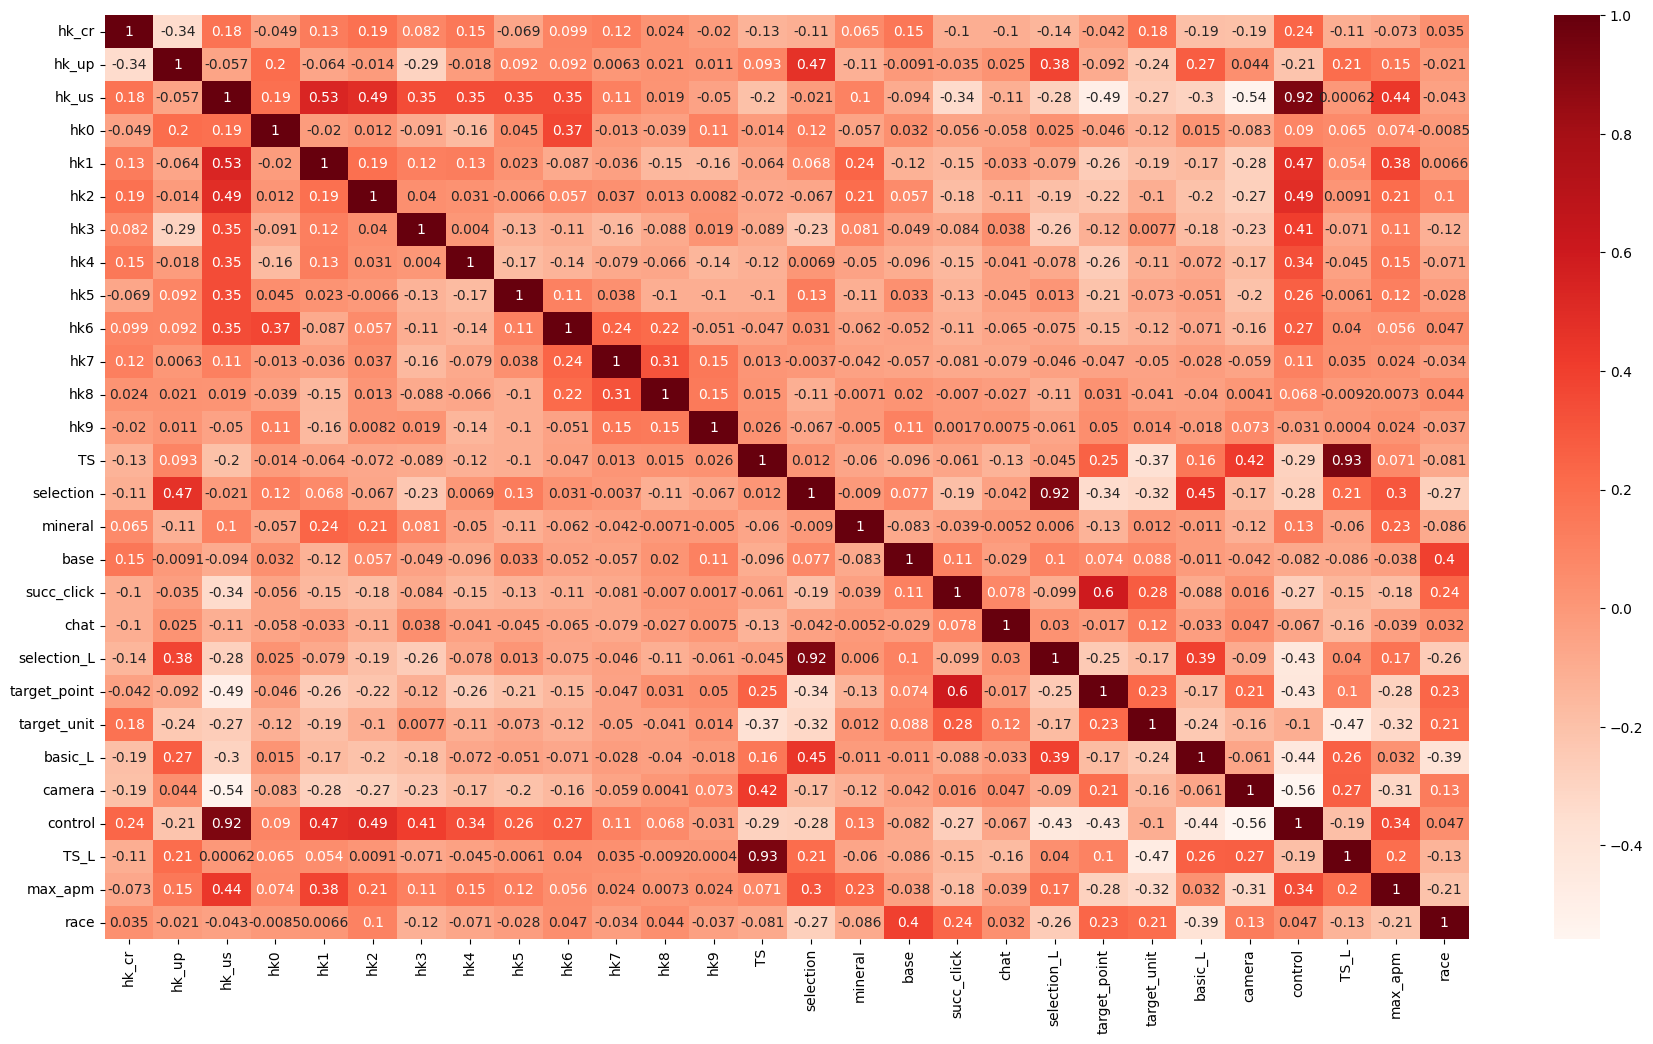

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
cor = X_T.corr()
plt.figure(figsize=(22,12))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [36]:
X_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hk_cr         3044 non-null   float64
 1   hk_up         3044 non-null   float64
 2   hk_us         3044 non-null   float64
 3   hk0           3044 non-null   float64
 4   hk1           3044 non-null   float64
 5   hk2           3044 non-null   float64
 6   hk3           3044 non-null   float64
 7   hk4           3044 non-null   float64
 8   hk5           3044 non-null   float64
 9   hk6           3044 non-null   float64
 10  hk7           3044 non-null   float64
 11  hk8           3044 non-null   float64
 12  hk9           3044 non-null   float64
 13  TS            3044 non-null   float64
 14  selection     3044 non-null   float64
 15  mineral       3044 non-null   float64
 16  base          3044 non-null   float64
 17  succ_click    3044 non-null   float64
 18  chat          3044 non-null 

In [37]:
# Feature selection
X_TD = X_T.copy()
# X_TD = X_TD.drop(['race'], axis=1)
# X_TD = X_TD.drop(['mineral'], axis=1)
X_TD = X_TD.drop(['TS'], axis=1)
#X_TD = X_TD.drop(['TS_L'], axis=1)
X_TD = X_TD.drop(['selection'], axis=1)
# X_TD = X_TD.drop(['selection_L'], axis=1)
#X_TD = X_TD.drop(['hk_us'], axis=1)
X_TD = X_TD.drop(['control'], axis=1)
# X_TD = X_TD.drop(['chat'], axis=1)
# X_TD = X_TD.drop(['camera'], axis=1)
#  X_TD = X_TD.drop(['succ_click'], axis=1)
X_TD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hk_cr         3044 non-null   float64
 1   hk_up         3044 non-null   float64
 2   hk_us         3044 non-null   float64
 3   hk0           3044 non-null   float64
 4   hk1           3044 non-null   float64
 5   hk2           3044 non-null   float64
 6   hk3           3044 non-null   float64
 7   hk4           3044 non-null   float64
 8   hk5           3044 non-null   float64
 9   hk6           3044 non-null   float64
 10  hk7           3044 non-null   float64
 11  hk8           3044 non-null   float64
 12  hk9           3044 non-null   float64
 13  mineral       3044 non-null   float64
 14  base          3044 non-null   float64
 15  succ_click    3044 non-null   float64
 16  chat          3044 non-null   float64
 17  selection_L   3044 non-null   float64
 18  target_point  3044 non-null 

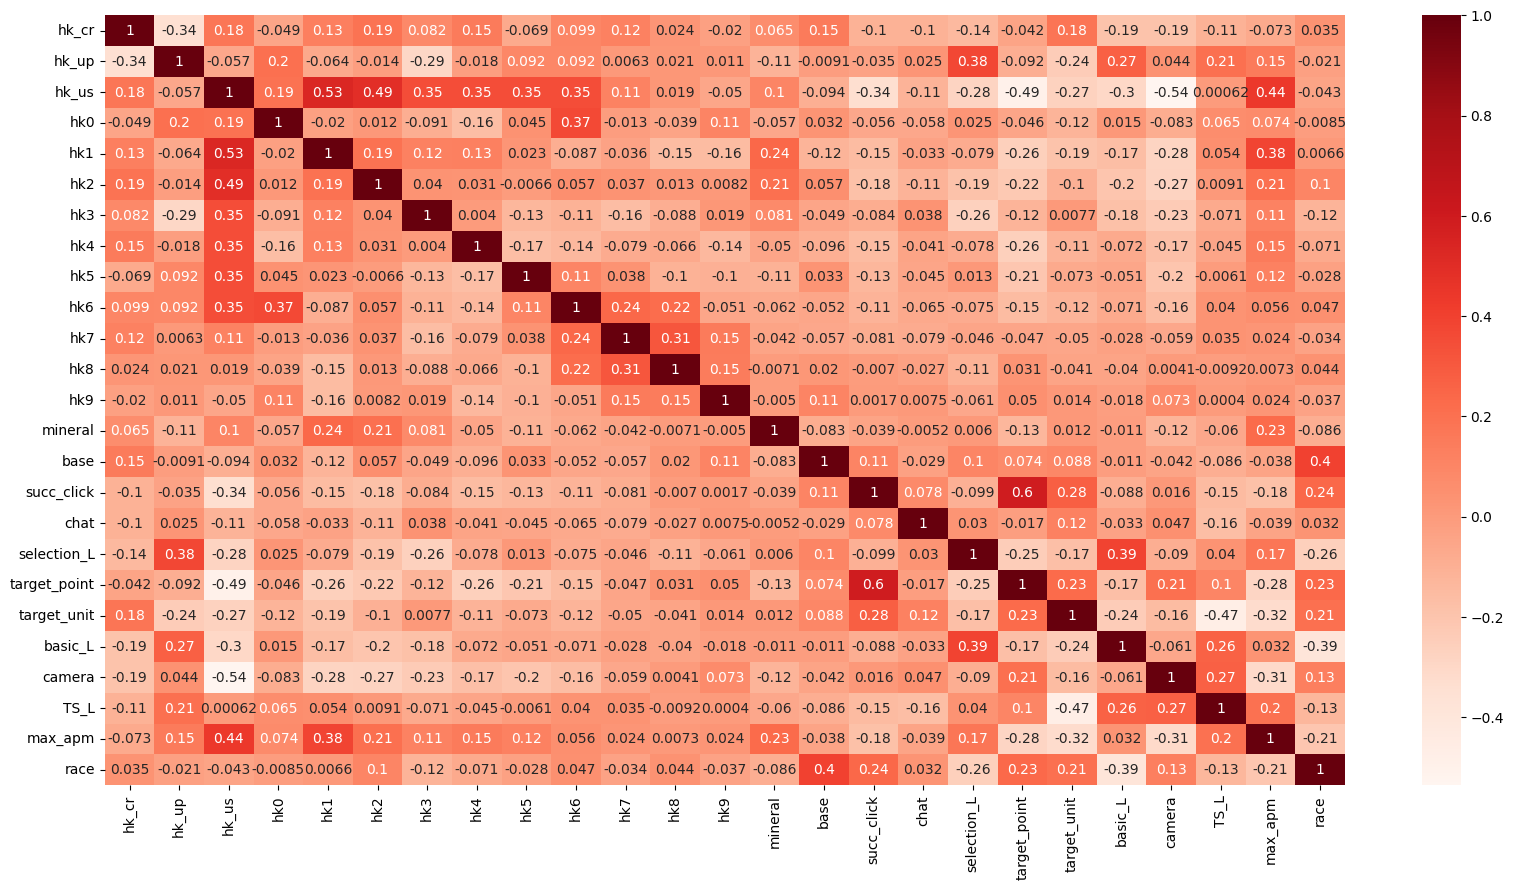

In [38]:
cor = X_TD.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [39]:
# Get labels
y = df['battleneturl'].values
print(y)

['http://eu.battle.net/sc2/en/profile/4234852/1/First/'
 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/'
 'http://eu.battle.net/sc2/en/profile/4234852/1/First/' ...
 'http://xx.battle.net/sc2/en/profile/405/1/MMA/'
 'http://xx.battle.net/sc2/en/profile/410/1/STBomber/'
 'http://xx.battle.net/sc2/en/profile/405/1/MMA/']


### As we can see before, our dataset is unbalanced. We will oversample to 10 for the minority classes which has less than 10 rows of data. We initially thought this was a very good operation, but we'll end up discussing it in the summary. This part is just to give a visualization of oversampling. We won't use it to train and test our model.

### Later, we will just oversample the training set. Because the purpose of validation and test sets is to evaluate the performance of the model on unseen data. These data sets should be as representative as possible of real-world data distributions. If validation or test sets are oversampled, they no longer represent the real data distribution and thus cannot accurately assess the model's performance in real-world applications.

In [40]:
# Oversampling
from sklearn.utils import resample

# Set the threshold below which classes will be oversampled
threshold = 10
# Count the number of players in the minority classes 
min_player = 0
# Get the counts of each class
X_TD['battleneturl'] = df['battleneturl']
class_counts = X_TD['battleneturl'].value_counts()
# Initialize an empty DataFrame to store the resampled data
X_resampled = pd.DataFrame(columns=X_TD.columns)
# Resample each class
for class_label, count in class_counts.items():
    X_class = X_TD[X_TD['battleneturl'] == class_label]
    if count < threshold:
        min_player += 1
        # If the class count is below the threshold, oversample it
        X_class_resampled = resample(X_class, 
                                      replace=True,     # sample with replacement
                                      n_samples=10,    # to match maximum class count
                                      random_state=123) # reproducible results
    else:
        # If the class count is above the threshold, keep it as is
        X_class_resampled = X_class
    if not X_class_resampled.empty:  # Check if X_class_resampled has data
        X_resampled = pd.concat([X_resampled, X_class_resampled])

# Display new class counts
print(X_resampled['battleneturl'].value_counts().reset_index())
X_resampled = X_resampled.reset_index()
print(f'Number of players needed to oversample: {min_player}')

/tmp/ipykernel_42/3604221764.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_resampled = pd.concat([X_resampled, X_class_resampled])


                                          battleneturl  count
0    http://kr.battle.net/sc2/en/profile/2348639/1/...     58
1    http://kr.battle.net/sc2/en/profile/2342419/1/...     51
2    http://kr.battle.net/sc2/en/profile/2341467/1/...     50
3    http://eu.battle.net/sc2/en/profile/3973341/1/...     44
4    http://kr.battle.net/sc2/en/profile/2332264/1/...     42
..                                                 ...    ...
195  http://eu.battle.net/sc2/en/profile/2685580/1/...     10
196  http://kr.battle.net/sc2/en/profile/2344407/1/...     10
197  http://us.battle.net/sc2/en/profile/4609532/1/...     10
198  http://kr.battle.net/sc2/en/profile/1126978/2/...     10
199     http://xx.battle.net/sc2/en/profile/405/1/MMA/     10

[200 rows x 2 columns]
Number of players needed to oversample: 71


### Once again, this image shows us the imbalance of the dataset. Nearly 36% of the players have less than 10 rows of data.

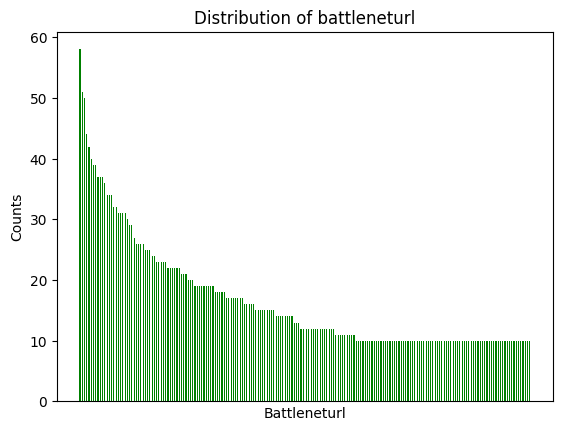

In [41]:
X_resampled['battleneturl'].hist(bins=400, grid=False, color='green')
plt.title('Distribution of battleneturl')
plt.xlabel('Battleneturl')
plt.xticks([])  # remove x-axis ticks
plt.ylabel('Counts')
plt.show()

In [42]:
X_resampled = X_resampled.drop('index', axis = 1)
X_resampled = X_resampled.drop(['battleneturl'], axis=1)
X_TD = X_TD.drop(['battleneturl'], axis=1)
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3334 entries, 0 to 3333
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hk_cr         3334 non-null   float64
 1   hk_up         3334 non-null   float64
 2   hk_us         3334 non-null   float64
 3   hk0           3334 non-null   float64
 4   hk1           3334 non-null   float64
 5   hk2           3334 non-null   float64
 6   hk3           3334 non-null   float64
 7   hk4           3334 non-null   float64
 8   hk5           3334 non-null   float64
 9   hk6           3334 non-null   float64
 10  hk7           3334 non-null   float64
 11  hk8           3334 non-null   float64
 12  hk9           3334 non-null   float64
 13  mineral       3334 non-null   float64
 14  base          3334 non-null   float64
 15  succ_click    3334 non-null   float64
 16  chat          3334 non-null   float64
 17  selection_L   3334 non-null   float64
 18  target_point  3334 non-null 

# Machine Learning Modeling

### We divide the dataset into two parts, 80% of the data for the training set and the remaining 20% for the validation set to select the hyperparameters and compare the performance of the models. In fact, we start out using k-fold cross-validation, and at the suggestion of our teacher and under the influence of the unbalanced dataset, we end up separating the dataset directly by 0.8 and 0.2.

### For the regression algorithm, the neural network converges faster while ensuring that each feature contributes equally to the weight calculation, preventing problems due to different feature scales. We chose to standardize the data for the whole dataset. Even we want to test on test set, we will use the the same standarization transformation.

### In this section, we also apply the stratify strategy. Because when we split the original dataset, since we have unbalanced dataset, it is possible that for a particular player all the data are randomly assigned to the validation set. However, we never trained on the training set. This will obviously affect the prediction for this player.

In [43]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Standardization
stds = StandardScaler()
# Fit and transform the data
X_T_S = stds.fit_transform(X_TD)
# Label encoding to convert string labels to numerical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded, np.max(y_encoded), np.min(y_encoded))
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_TD, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_T_S, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

[ 53  29  53 ... 192 196 192] 199 0


### This part is oversampling for training set as we explained before. In the future, maybe we can try a more advenced algorithme like SMOTE. 

In [44]:
from imblearn.over_sampling import SMOTE
# Check the size of the minority class
unique, counts = np.unique(y_train_S, return_counts=True)
class_distribution = dict(zip(unique, counts))
min_class_size = min(class_distribution.values())

print("Class distribution:", class_distribution)
print("Minimum class size:", min_class_size)

# Ensure k_neighbors is less than the number of samples in the minority class
k_neighbors = min(min_class_size - 1, 5)  # Adjusting to a safe value
print("k_neighbors set to:", k_neighbors)

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_S_resampled, y_train_S_resampled = smote.fit_resample(X_train_S, y_train_S)
print(X_train_S_resampled)

Class distribution: {0: 16, 1: 7, 2: 10, 3: 20, 4: 12, 5: 10, 6: 9, 7: 10, 8: 10, 9: 13, 10: 6, 11: 13, 12: 9, 13: 11, 14: 5, 15: 10, 16: 29, 17: 23, 18: 12, 19: 6, 20: 6, 21: 11, 22: 6, 23: 6, 24: 25, 25: 29, 26: 11, 27: 6, 28: 17, 29: 29, 30: 10, 31: 15, 32: 14, 33: 10, 34: 17, 35: 25, 36: 3, 37: 5, 38: 10, 39: 8, 40: 21, 41: 6, 42: 6, 43: 15, 44: 15, 45: 11, 46: 8, 47: 14, 48: 8, 49: 35, 50: 14, 51: 10, 52: 22, 53: 12, 54: 6, 55: 6, 56: 3, 57: 9, 58: 10, 59: 18, 60: 23, 61: 18, 62: 8, 63: 6, 64: 4, 65: 4, 66: 33, 67: 18, 68: 6, 69: 14, 70: 18, 71: 3, 72: 14, 73: 40, 74: 19, 75: 7, 76: 17, 77: 25, 78: 6, 79: 9, 80: 24, 81: 21, 82: 18, 83: 6, 84: 3, 85: 25, 86: 41, 87: 5, 88: 12, 89: 9, 90: 10, 91: 3, 92: 8, 93: 18, 94: 15, 95: 27, 96: 29, 97: 3, 98: 19, 99: 20, 100: 31, 101: 27, 102: 6, 103: 27, 104: 9, 105: 25, 106: 18, 107: 9, 108: 18, 109: 5, 110: 3, 111: 14, 112: 31, 113: 11, 114: 10, 115: 4, 116: 18, 117: 16, 118: 9, 119: 15, 120: 21, 121: 6, 122: 15, 123: 25, 124: 3, 125: 3, 12

In [45]:
# Oversampling for training set
threshold = 10
# Add 'battleneturl' temporarily to X_train for resampling
X_train['battleneturl'] = y_train
label_counts = X_train['battleneturl'].value_counts()
# Initialize an empty DataFrame for the resampled data
X_train_resampled = pd.DataFrame(columns=X_train.columns)
# Resample each class
for label_count, count in label_counts.items():
    X_label = X_train[X_train['battleneturl'] == label_count]
    if count < threshold:
        # Oversample if below the threshold
        X_label_resampled = resample(X_label, replace=True, n_samples=threshold, random_state=123)
    else:
        # Keep as is if above the threshold
        X_label_resampled = X_label
    X_train_resampled = pd.concat([X_train_resampled, X_label_resampled])
# Removing the 'battleneturl' column and updating y_train accordingly
y_train_resampled = X_train_resampled['battleneturl']
X_train_resampled = X_train_resampled.drop(columns=['battleneturl'])
X_train = X_train.drop(columns=['battleneturl'])
# Reset index
X_train_resampled = X_train_resampled.reset_index(drop=True)
y_train_resampled = y_train_resampled.reset_index(drop=True)
X_train_resampled.info()
print(y_train_resampled)
y_train_resampled = y_train_resampled.values
y_train_resampled = label_encoder.fit_transform(y_train_resampled)

/tmp/ipykernel_42/1116708899.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train_resampled = pd.concat([X_train_resampled, X_label_resampled])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hk_cr         2835 non-null   float64
 1   hk_up         2835 non-null   float64
 2   hk_us         2835 non-null   float64
 3   hk0           2835 non-null   float64
 4   hk1           2835 non-null   float64
 5   hk2           2835 non-null   float64
 6   hk3           2835 non-null   float64
 7   hk4           2835 non-null   float64
 8   hk5           2835 non-null   float64
 9   hk6           2835 non-null   float64
 10  hk7           2835 non-null   float64
 11  hk8           2835 non-null   float64
 12  hk9           2835 non-null   float64
 13  mineral       2835 non-null   float64
 14  base          2835 non-null   float64
 15  succ_click    2835 non-null   float64
 16  chat          2835 non-null   float64
 17  selection_L   2835 non-null   float64
 18  target_point  2835 non-null 

### First, we try a simple logstic regression and get a accceptable ressult. However, we encountered convergence problems, so we increased the number of iterations to 1000. We specify the solver **lbfgs**, it's efficient for small to medium-sized datasets and also generally converges faster than gradient descent for logistic regression.

In [46]:
# Logistic regression
lr = LogisticRegression(max_iter=1000, solver='lbfgs')
lr.fit(X_train_S, y_train_S)
y_lr = lr.predict(X_test_S)
lr_f1 = f1_score(y_test_S, y_lr, average='macro')
print(f'F1-score of Logistic Regression: {lr_f1:.4f}')
# Perform k-fold cross-validation with F1-score
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# f1_scores_lr = cross_val_score(lr, X_new, y_encoded, cv=kfold, scoring='f1_macro') # X_T
# Calculate the mean F1-score across all folds
# mean_f1_score_lr = np.mean(f1_scores_lr)
# print(f'Mean F1-score of Logistic Regression: {mean_f1_score_lr:.4f}')

F1-score of Logistic Regression: 0.7841


### Second, we use another classic algorithm, the decision tree. Here is some hyperparameter that we can manipulate:

* max_depth: The maximum depth of tree, If None, the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* min_samples_split: The minimum number of samples a node must have before this node is allowed to be split. Large values prevent overfitting but may also lead to underfitting.
* min_samples_leaf: The minimum number of samples a leaf node must have. 
* max_leaf_nodes: Maximum number of leaf nodes to prevent the tree from becoming too large
* min_impurity_decrease: A node will be split if its splitting results in a decrease in impurity greater than or equal to this value. This can be used for pre-pruning.
* class_weight: Specifies the class weight

### Since we have already dealt with the imbalance, we do not use the last hyperparameter.

In [47]:
# Decision Tree
dt = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=2)
dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)
dt_f1 = f1_score(y_test, y_dt, average='macro')
print(f'F1-score of Decision Tree: {dt_f1:.4f}')

F1-score of Decision Tree: 0.6006


### When we try the same algorithme decision trees for on versampling data, we notice that

In [48]:
dt_r = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=2)
dt_r.fit(X_train_resampled, y_train_resampled)
y_dt_r = dt_r.predict(X_test)
dt_r_f1 = f1_score(y_test, y_dt_r, average='macro')
print(f'F1-score of Decision Tree - R: {dt_r_f1:.4f}')

F1-score of Decision Tree - R: 0.6430


### Third, we want to train a random forest classifier which is a collection of multiple decision trees using sampling with replacement and it ends up using voting to arrive at the final result. So random forests are more robust and generalize better. About the hyperparameter, we can set the number of trees. In addition, we keep the same criterion as decision trees, it's **gini** indicator.

* n_estimators: The number of trees in the forest. Increasing the number of trees can improve the model's performance but also increases computational cost.
* criterion: The function used to measure the quality of a split, by default is 'gini'.

In [49]:
# Random Forest 
from sklearn import tree
rf = RandomForestClassifier(max_depth = 35)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
rf_f1 = f1_score(y_test, y_rf, average='macro')
print(f'F1-score of Random Forest: {rf_f1:.4f}')

F1-score of Random Forest: 0.8335


In [50]:
rf_r = RandomForestClassifier(max_depth = 35)
rf_r.fit(X_train_resampled, y_train_resampled)
y_rf_r = rf_r.predict(X_test)
rf_r_f1 = f1_score(y_test, y_rf_r, average='macro')
print(f'F1-score of Random Forest - R: {rf_r_f1:.4f}')

F1-score of Random Forest - R: 0.8480


In [51]:
# Get the depth of each tree in the forest
tree_depths = [tree.tree_.max_depth for tree in rf.estimators_]
# Analyze the tree depths
max_depth = max(tree_depths)
min_depth = min(tree_depths)
average_depth = sum(tree_depths) / len(tree_depths)
print(f"Maximum depth in Random Forest: {max_depth}")
print(f"Minimum depth in Random Forest: {min_depth}")
print(f"Average depth in Random Forest: {average_depth}")

Maximum depth in Random Forest: 35
Minimum depth in Random Forest: 19
Average depth in Random Forest: 24.49


### Now, we get a nice result and want to look at the feature importance of random forest classifier to help us further select the feature, as we explained earlier.

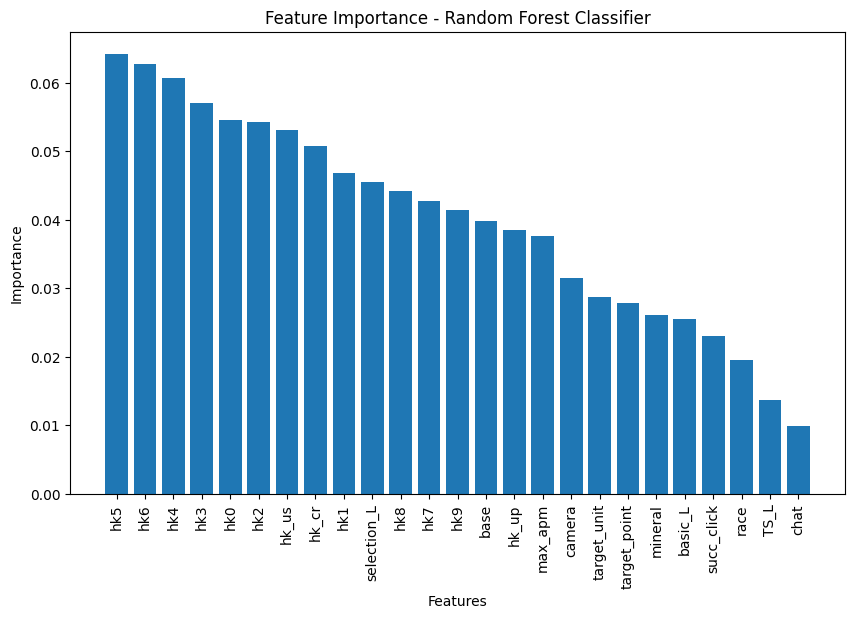

In [52]:
# Feature Importance
# Get feature importances
importances = rf.feature_importances_
# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]
# Rearrange feature names based on importance ranking
names = [X_TD.columns[i] for i in indices]
# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest Classifier")
plt.bar(range(X_TD.shape[1]), importances[indices], align="center")
plt.xticks(range(X_TD.shape[1]), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('RF_IMP.png')
plt.show()

### It's interesting if we compare the feature importance of two random forest models. We observe some changes in the ordering of feature importance compared to the previous model. We can hypothesize that those features that become more important are also important for the data from the minority classes.

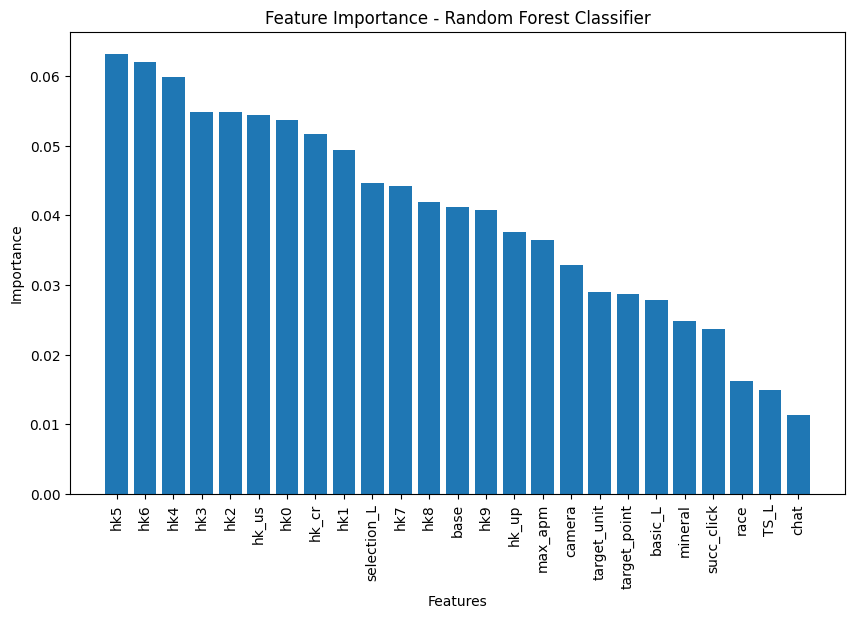

In [53]:
importances = rf_r.feature_importances_
# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]
# Rearrange feature names based on importance ranking
names = [X_resampled.columns[i] for i in indices]
# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest Classifier")
plt.bar(range(X_resampled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_resampled.shape[1]), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### We are also very curious about our tree. Therefore, we try to visualize the nodes in the tree. We have a little discovery, it seems like features close to the root node are more important but it's not always the case. We observe also some important features appear very deep. So there is no directly link between the position and te importance of the features. All depend on the calculation of impurity and gini metric.

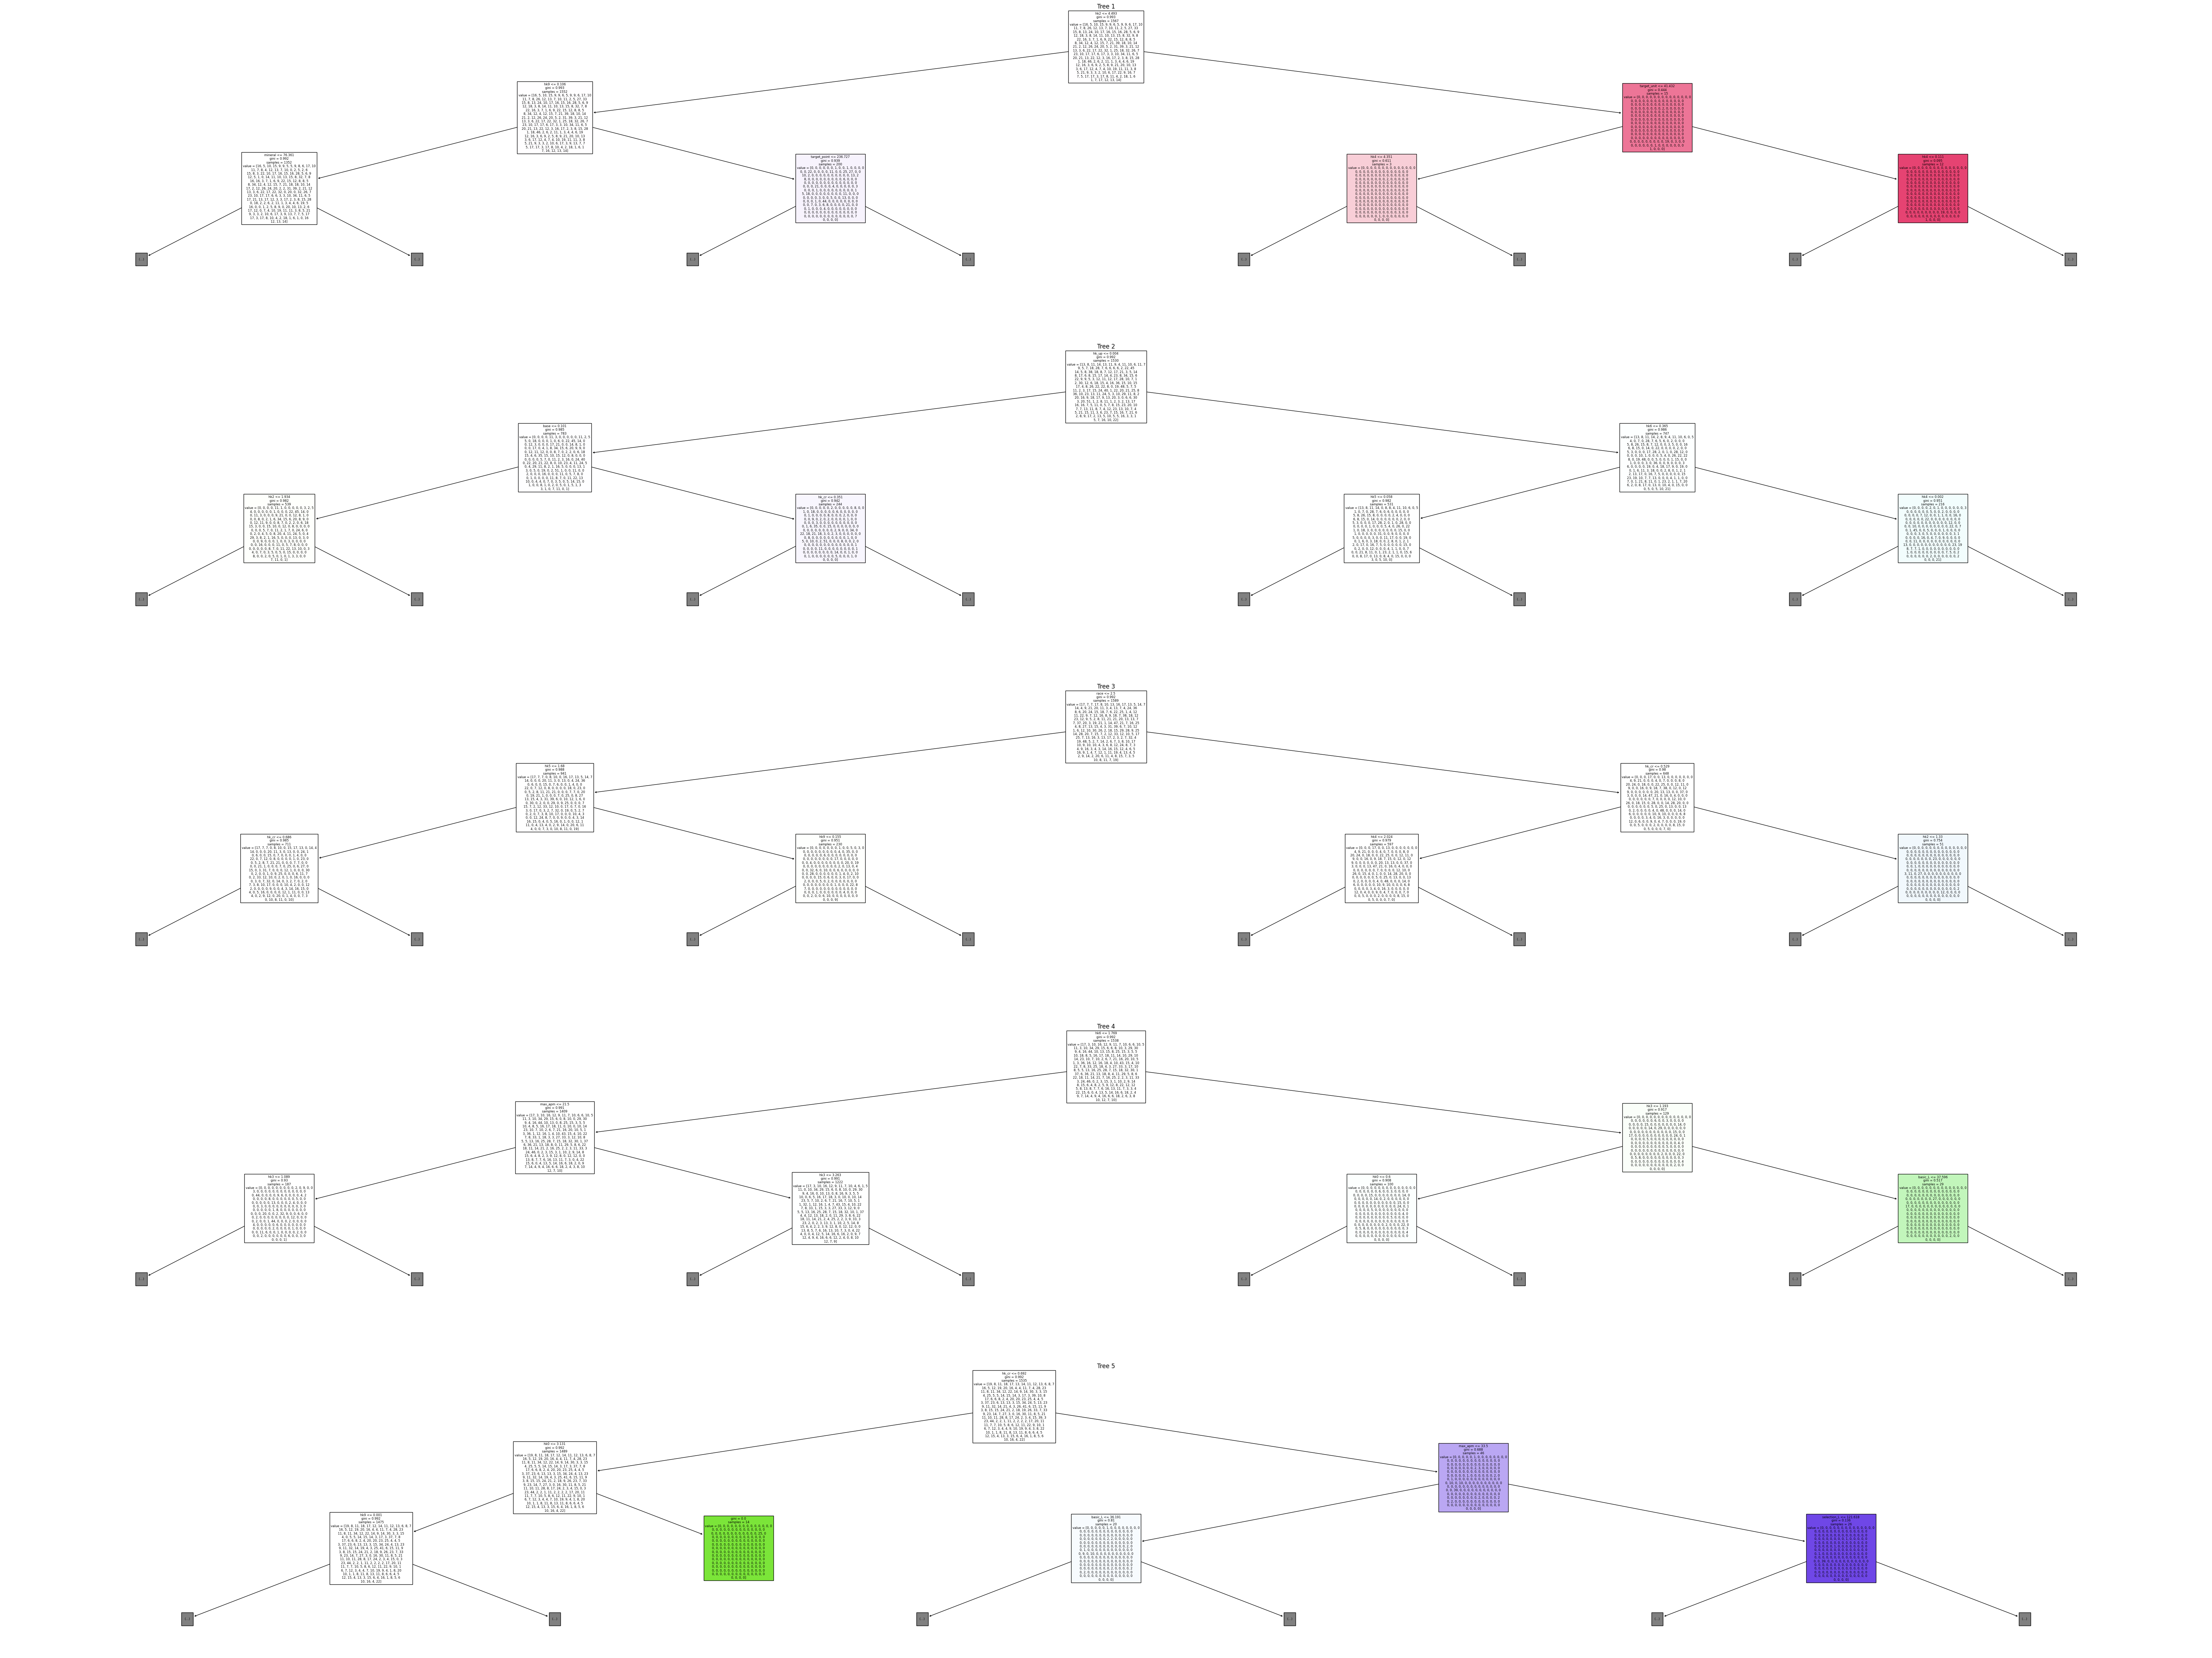

In [54]:
# Visualize tree
from sklearn.tree import plot_tree
fig, axs = plt.subplots(5, 1, figsize=(80, 60))
for i in range(5):
    plot_tree(rf.estimators_[i], max_depth=2, filled=True, feature_names=X_TD.columns.tolist(), ax=axs[i])
    axs[i].set_title(f'Tree {i + 1}')
plt.show()

### Fourth, we implement the XGBoost model. If we want to compare with the random forest, random forest builds trees in parallel and independently, whereas XGBoost builds them sequentially in a boosting manner. It means that each new tree in XGBoost is built to correct the errors made by previous ones. In general, random forest focus on the variance and XGBoost pays more attention to reduce the bias. Here is some hyperparameters below:

* learning_rate: Step size shrinkage used to prevent overfitting.
* n_estimators: Same as random forest
* max_depth: Same as decision tree
* min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
* gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
* reg_lambda: L2 regularization term on weights

### In the end, we don't get better results than random forests. Maybe we encounter an overfitting problem or we don't tune the hyperparameters enough.

In [55]:
# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth = 35)
xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_test)
xgb_f1 = f1_score(y_test, y_xgb, average='macro')
print(f'F1-score of XGBoost: {xgb_f1:.4f}')

F1-score of XGBoost: 0.7362


In [56]:
xgb_model_r = xgb.XGBClassifier(max_depth = 35)
xgb_model_r.fit(X_train_resampled, y_train_resampled)
y_xgb_r = xgb_model_r.predict(X_test)
xgb_r_f1 = f1_score(y_test, y_xgb_r, average='macro')
print(f'F1-score of XGBoost - R: {xgb_r_f1:.4f}')

F1-score of XGBoost - R: 0.7287


### Fifth, we realize a neural network with some strategies like regularization, dropout and early stopping to avoid the overfitting problem. 

In [78]:
# NN
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

y_one_hot = to_categorical(y_train_S, num_classes=200) # y_train_S_resampled
y_test_one_hot = to_categorical(y_test_S, num_classes=200)
# Build the neural network model
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(25,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(200, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])
# Compile the model with the F1-score metric
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
nn.compile(optimizer=optimizer, loss='categorical_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history_nn = nn.fit(X_train_S, y_one_hot, epochs=60, batch_size=32, validation_data=(X_test_S, y_test_one_hot), callbacks=[early_stopping])# X_train_S_resampled
# F1-score on validation set
y_nn = nn.predict(X_test_S)
y_nn_encoded = np.argmax(y_nn, axis=1)
y_test_encoded = np.argmax(y_test_one_hot, axis=1)
nn_f1 = f1_score(y_test_encoded, y_nn_encoded, average='macro')
print(f'F1-score of Neutral Network - R: {nn_f1:.4f}')

Epoch 1/60
77/77 [==============================] - 2s 10ms/step - loss: 6.1597 - accuracy: 0.0821 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 5.8537 - val_accuracy: 0.1987 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/60
77/77 [==============================] - 0s 5ms/step - loss: 5.5938 - accuracy: 0.2181 - precision_9: 1.0000 - recall_9: 0.0029 - val_loss: 5.2165 - val_accuracy: 0.2906 - val_precision_9: 1.0000 - val_recall_9: 0.0099
Epoch 3/60
77/77 [==============================] - 0s 5ms/step - loss: 4.9550 - accuracy: 0.3125 - precision_9: 0.9500 - recall_9: 0.0234 - val_loss: 4.5601 - val_accuracy: 0.4089 - val_precision_9: 0.9474 - val_recall_9: 0.0296
Epoch 4/60
77/77 [==============================] - 0s 5ms/step - loss: 4.3254 - accuracy: 0.4218 - precision_9: 0.9196 - recall_9: 0.0423 - val_loss: 3.9618 - val_accuracy: 0.5074 - val_precision_9: 0.9767 - val_recall_9: 0.0690
Epoch 5/60
77/77 [==============================] - 0s 5ms/step

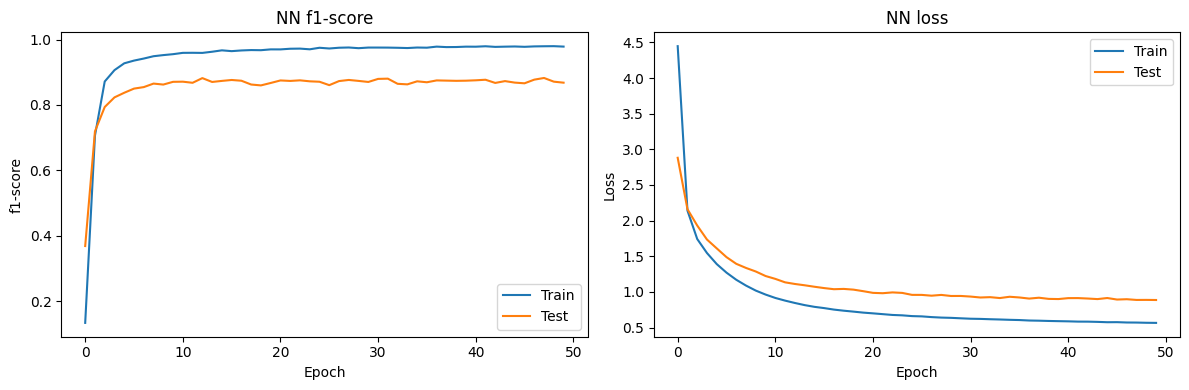

In [58]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
pr_nn = np.array(history_nn.history['precision'])
rc_nn = np.array(history_nn.history['recall'])
pr_nn_val = np.array(history_nn.history['val_precision'])
rc_nn_val = np.array(history_nn.history['val_recall'])
plt.plot(np.nan_to_num(2 * (pr_nn * rc_nn) / (pr_nn + rc_nn)))
plt.plot(np.nan_to_num(2 * (pr_nn_val * rc_nn_val) / (pr_nn_val + rc_nn_val)))
plt.title('NN f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('NN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

### Finally, it's our LSTM model. We will not present the formulas to compute the **update**, **forget** and **output** coefficents and LSTM architecture. Our objectif is just to explore the feasibility of time series modeling. In the end, however, we don't get a particularly good result. We will discuss this further in the summary.

In [62]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

y_one_hot_lstm = to_categorical(y_encoded, num_classes=200)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(df_seq, y_one_hot_lstm, test_size=0.2,stratify=y_encoded, random_state=42)
# Build LSTM model
lstm = Sequential()
lstm.add(LSTM(20, input_shape=(1000, 1)))#, return_sequences=True)) # sequence length of 1000 and 1 feature
# lstm.add(LSTM(20, return_sequences=True))
#lstm.add(LSTM(20))
lstm.add(Dense(200, activation='softmax'))
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# Train the model
history_lstm = lstm.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))
# F1-score on validation set
y_lstm = lstm.predict(X_test_lstm)
y_lstm_encoded = np.argmax(y_lstm, axis=1)
y_test_encoded_lstm = np.argmax(y_test_lstm, axis=1)
lstm_f1 = f1_score(y_test_encoded_lstm, y_lstm_encoded, average='macro')
print(f'F1-score of LSTM: {lstm_f1:.4f}')

Epoch 1/300
77/77 [==============================] - 6s 41ms/step - loss: 5.1975 - accuracy: 0.0148 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 5.0486 - val_accuracy: 0.0197 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/300
77/77 [==============================] - 2s 32ms/step - loss: 4.9650 - accuracy: 0.0263 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 4.8556 - val_accuracy: 0.0263 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/300
77/77 [==============================] - 2s 31ms/step - loss: 4.8103 - accuracy: 0.0312 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 4.8577 - val_accuracy: 0.0263 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/300
77/77 [==============================] - 2s 32ms/step - loss: 4.7790 - accuracy: 0.0287 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 4.7181 - val_accuracy: 0.0312 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/

/tmp/ipykernel_42/2451456882.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.nan_to_num(2 * (pr_lstm * rc_lstm) / (pr_lstm + rc_lstm)))
/tmp/ipykernel_42/2451456882.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.nan_to_num(2 * (pr_lstm_val * rc_lstm_val) / (pr_lstm_val + rc_lstm_val)))


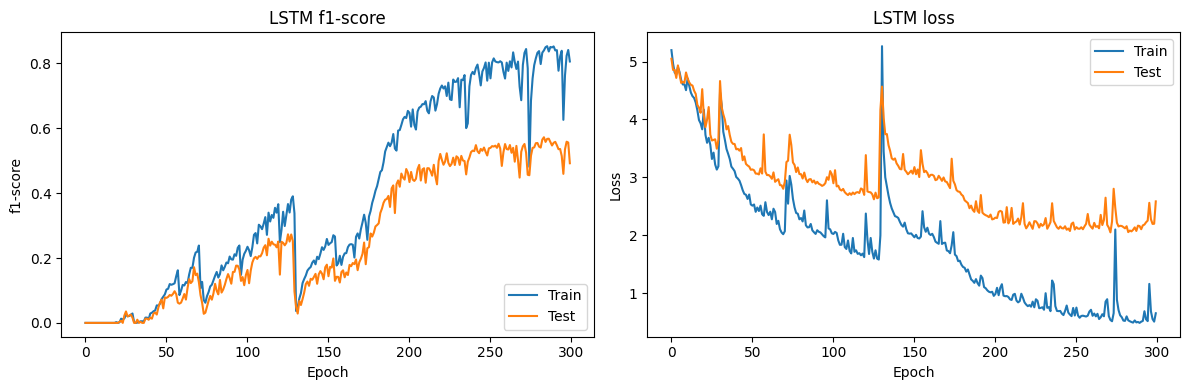

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
pr_lstm = np.array(history_lstm.history['precision_1'])
rc_lstm = np.array(history_lstm.history['recall_1'])
pr_lstm_val = np.array(history_lstm.history['val_precision_1'])
rc_lstm_val = np.array(history_lstm.history['val_recall_1'])
plt.plot(np.nan_to_num(2 * (pr_lstm * rc_lstm) / (pr_lstm + rc_lstm)))
plt.plot(np.nan_to_num(2 * (pr_lstm_val * rc_lstm_val) / (pr_lstm_val + rc_lstm_val)))
plt.title('LSTM f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

# TEST

### This part is to generate CSV file for submitting the result on Kaggle. 

In [64]:
# Transform new data
df_Test = read_ds('/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST.CSV.GZ')
df_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Columns: 6818 entries, played_race to 6816
dtypes: object(6818)
memory usage: 17.7+ MB


In [65]:
df_Test_L = read_ds('/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST_LONG.CSV.GZ')
df_Test_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Columns: 14626 entries, played_race to 14624
dtypes: object(14626)
memory usage: 37.9+ MB


In [66]:
X_Test = create_df(df_Test)
X_Test = X_Test.astype(float)
X_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hk_cr      340 non-null    float64
 1   hk_up      340 non-null    float64
 2   hk_us      340 non-null    float64
 3   hk0        340 non-null    float64
 4   hk1        340 non-null    float64
 5   hk2        340 non-null    float64
 6   hk3        340 non-null    float64
 7   hk4        340 non-null    float64
 8   hk5        340 non-null    float64
 9   hk6        340 non-null    float64
 10  hk7        340 non-null    float64
 11  hk8        340 non-null    float64
 12  hk9        340 non-null    float64
 13  TS         340 non-null    float64
 14  selection  340 non-null    float64
 15  mineral    340 non-null    float64
 16  base       340 non-null    float64
dtypes: float64(17)
memory usage: 45.3 KB


In [67]:
# LONG dataset's features
succ_select_Test = count_succ_click(df_Test_L)
X_Test['succ_click'] = succ_select_Test
chat_Test, selection_L_Test, camera_Test, target_point_Test, control_Test, target_unit_Test, basic_L_Test, TS_L_Test = count_event(df_Test_L)
X_Test['chat'] = chat_Test
X_Test['selection_L'] = selection_L_Test
X_Test['target_point'] = target_point_Test
X_Test['target_unit'] = target_unit_Test
X_Test['basic_L'] = basic_L_Test
X_Test['camera'] = camera_Test
X_Test['control'] = control_Test
X_Test['TS_L'] = TS_L_Test
X_Test = X_Test.astype(float)
# Transform data
X_Test = transform_df(X_Test)
X_Test['max_apm'] = max_apm(df_Test)
X_Test = add_race(df_Test, X_Test)

# Feature selection
# X_Test = X_Test.drop(['race'], axis=1)
X_Test = X_Test.drop(['TS'], axis=1)
# X_Test = X_Test.drop(['TS_L'], axis=1)
X_Test = X_Test.drop(['selection'], axis=1)
# X_Test = X_Test.drop(['selection_L'], axis=1)
#X_Test = X_Test.drop(['hk_us'], axis=1)
X_Test = X_Test.drop(['control'], axis=1)
# X_Test = X_Test.drop(['chat'], axis=1)

X_Test = X_Test.astype(float)
X_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hk_cr         340 non-null    float64
 1   hk_up         340 non-null    float64
 2   hk_us         340 non-null    float64
 3   hk0           340 non-null    float64
 4   hk1           340 non-null    float64
 5   hk2           340 non-null    float64
 6   hk3           340 non-null    float64
 7   hk4           340 non-null    float64
 8   hk5           340 non-null    float64
 9   hk6           340 non-null    float64
 10  hk7           340 non-null    float64
 11  hk8           340 non-null    float64
 12  hk9           340 non-null    float64
 13  mineral       340 non-null    float64
 14  base          340 non-null    float64
 15  succ_click    340 non-null    float64
 16  chat          340 non-null    float64
 17  selection_L   340 non-null    float64
 18  target_point  340 non-null    

In [71]:
# Test on new dataset
best_model = rf_r
#X_Test_S = stds.fit_transform(X_Test)
y_pred = best_model.predict(X_Test)# _S
y_pred_original_labels = label_encoder.inverse_transform(y_pred)# np.argmax(y_pred, axis=1)

In [72]:
# Generate CSV
data = {'RowId': list(range(1, 341)),
        'prediction': y_pred_original_labels}
df_res = pd.DataFrame(data)
df_res.tail()

RowId prediction
335    336         95
336    337         76
337    338        163
338    339        192
339    340        196

In [ ]:
df_res.to_csv('(QAQ).csv', index=False)

# Conclusion

### Our conclusion hopes to identify areas for improvement and further exploration.

### First , as you can see in our notebook, we used the following two approaches to solve this challenge. One is to extract new features to characterize the players and the dataset, and the other is to directly choose time series to make predictions about the players. In the first approach, stratify is a good strategy, but the use of oversampling is really debatable. This is because we found that the results were not as good as we expected in the final test set. We venture to guess that the player distribution is also unbalanced in the test set, so even if we learn more about the data of minority classes, the final result is not significantly better. Especially for our random forest model, the effect is even less obvious. Because we just repeat the already existing data, the decision conditions in the tree are exactly the same, only the position and gini coefficients are slightly changed. So in the future, maybe we can try **GAN** or **VAE** to generate more realistic data. Finally, our feature selection doesn't end there. We only used backward selection for a few features, so we will continue to test it when we have time. The other thing is to think about adding new features, but nevertheless, we got satisfactory results (0.8558) on our test set.

### Second, it's about our sequence model. We see two main difficulties. The first point is the handling of missing values. If we do segmentation only once, we need to make a trade-off between the number of missing values and losing more information. Maybe in the future we can try strategies such as multiple segmentation or sliding windows. The second point is the data type, as we explained before, we need a numeric type. In the case we just used a simple mapping, which would have lost the relationship between the texts. So we want to borrow **word2vec** from **NLP** to preserve the relationship between operations, such as **word embedding** algorithm. However, in our particular case, this is hard to control. Because for different players, the methods of defining hotkeys are completely different. That is to say, the same hotkey for different players may represent completely different operations. Finally, regarding the time series model, we have one other ongoing project is to analyze the behavior in the video. We use **XGBoost**, **LSTM**, **CNN (1D)**, and **Transformer** models. After our comparison, Transformer gives better results than CNN while CNN gives better results than LSTM. So in future, if we have time, we will implement the last two models as well. Among them, the Transformer model only needs the Encoder part to access another classifier. We mainly want to utilize the multi-head self-attention mechanism (there is only one head if we use the original data.) The Decoder's auto-regression generation model is not needed. All in all, we think the main difficulty is still the processing of time series data.

### At last, we thought it was a very interesting project. For us, exploring different possibilities is far more meaningful than spending time tweaking hyperparameters or doing feature selection. So we didn't end up with feature selection nor did we use grid search to find the best hyperparameters. But we practiced our data analysis skills and strengthened our machine learning foundation, and we benefited a lot from this project.

# END